In [1]:
import pyfftw
import modemc
import numpy as np
import matplotlib.pyplot as plt
import datetime, pickle, tempfile, time, sys, os
from helpers.sim_helper import *
from helpers import plotting
from IPython.display import clear_output

## 0. Todo

- Test the number of modes needed as a function of temperature (fixed T), and for T (fixed small beta and large beta). I think high temperatures require more modes as we need to be able to do loops back and forth.
- Test how many modes needed for both FW and OM. I suspect that for OM, we really should consider the action an action for paths in $C^1$, and so we should be able to use fewer modes but evaluate the integral with more quadrature nodes. FW should require more modes, but the integral should be considered a stochastic ito integral, so Nq=Nm.
- Autocorrelation tests
- ~Loop observable~
- Generate video of how state changes as a function of algorithmic time.
- ~Compute instantons of loops~, and compute a better approximate r2
- ~Burn-in~
- ~Investigate performance of FFT wrt Nm and whether to just use FFT isntead of DCT and DST.~
- ~Make sure pyfftw does preprocessing~
- Profiling
- Q matrix calculation is probably wrong.

## 1. Parameters

In [2]:
simulation_name = 'switch'
use_temp_folder = False
run_name = 'notebook'
run_info = run_name
ssh_comp = 'notebook'

In [3]:
use_default_params = True

In [4]:
# Load arguments if running as a script
if sys.argv[1] == "args":
    use_default_params = False
    
    use_temp_folder = False
    params_pkl_path = sys.argv[2]
    args_params = pickle.load(open(params_pkl_path, 'rb'))

    for param_k, param_v in args_params.items():
        globals()[param_k] = param_v

### System

In [5]:
if use_default_params:
    system_params = {
        'beta' : 10,
        'gamma' : 5,
        'Tf' : 10,

        'dim' : 2,

        'x0' : np.array([-1, 0]),
        'x1' : np.array([1, 0]),

        'U0' : 3,
        'xi1' : 0,
        'xi2' : 2,
    }

dict_to_global(system_params, globals())

### MCMC

In [6]:
if use_default_params:
    MCMC_params = {    
        'MCMC_protocol' : modemc.protocols.pCN_FFT_Flip,
        'use_OM' : True,
    
        'N_steps' : int(1e6),
        'N_burnin_ratio' : 0.3,

        'batch_size' : 1,
        'N_save' : int(1e6),
        'N_paths_save' : int(1e3),
        'N_obs_save' : int(3e6),
        'N_sim_verbose' : int(1e4),

        'Nm_save' : 20,
        'Nm_Tf_factor' : 200,

        'Nq_factor' : 1,
        'quad_scheme' : modemc.quad.uniform,

        'state0_choice' : 'upper_OM',

        'use_teleport' : True,
        'p_teleport' : 0, #1e-3,
        'teleporter_probs' : 'uniform',
        'teleporter_choice' : 'OM',
        
        'p_flip' : 1e-2,
        'flip_beta_threshold' : 50,
        
        'FFTW_planner_flag' : 'FFTW_EXHAUSTIVE', # FFTW_MEASURE, FFTW_PATIENT
        
        'enable_parallelisation': False,
    }

MCMC_params['Nm'] = int(np.round(system_params['Tf'] * MCMC_params['Nm_Tf_factor']))
MCMC_params['system'] = modemc.systems.Switch(system_params)
MCMC_params['N_burn_in'] = int(np.round(MCMC_params['N_steps'] * MCMC_params['N_burnin_ratio']))

dict_to_global(MCMC_params, globals(), deal_with_overwrites=True)

In [7]:
if use_default_params:
    analysis_params = {
        #'N_trace_observable' : 1,
        #'trace_observable_rms_window' : 10,
        'valid_path_channel_boundary' : 0.1,
    }

dict_to_global(analysis_params, globals())

In [8]:
if use_default_params:
    teleporter_params = {
        'teleporter_Nm_Tf_factor' : 10,
        'Q_Nm_Tf_factor' : 5,
        'Q_band_size_Nm_Tf_factor' : 10,
        'Q_Nq_factor' : 12,
        'Q_quad_scheme' : modemc.quad.clenshaw_curtis,
        'teleporter_Q_use_OM' : False,
        'N_instanton_loops' : 1,
    }

teleporter_params['teleporter_Nm'] = int(np.round(system_params['Tf'] * teleporter_params['teleporter_Nm_Tf_factor']))
teleporter_params['Q_band_size'] = int(np.round(system_params['Tf'] * teleporter_params['Q_band_size_Nm_Tf_factor']))
    
dict_to_global(teleporter_params, globals())

### Calibration

In [9]:
if use_default_params:
    instanton_finder_params = {
        'instanton_finder_Nm_Tf_factor' : 5,
        'instanton_finder_Nq_factor' : 12,
        'max_steps' : int(1e4),
        'ag_c' : 1e-6,
        'S_tol' : 1e-20,
        'gradS_tol' : 1e-6,
        'step_size0' : 0.1,
        'step_size_rate' : 0.99,
        'min_step_size' : 1e-60,
        'quad_scheme' : modemc.quad.clenshaw_curtis,
        'verbose' : True,
    }

instanton_finder_params['system'] = system
instanton_finder_params['Nm'] = int(np.round(instanton_finder_params['instanton_finder_Nm_Tf_factor'] * system_params['Tf']))
instanton_finder_params['Nq'] = int(np.round(instanton_finder_params['instanton_finder_Nq_factor'] * instanton_finder_params['Nm']))
    
dict_to_global(instanton_finder_params, globals(), prefix='instanton_finder')

In [10]:
if use_default_params:
    kappa_finder_params = {
        'targ_acc' : 0.3,
        'trial_N_sim' : int(1e4),
        'maxiter' : 20,
        'MCMC_params' : MCMC_params,
        'p_teleport' : 0.01, # Use a more frequent p_teleport in the kappa finder to properly probe it
    }

kappa_finder_params['MCMC_protocol'] = MCMC_protocol
    
dict_to_global(kappa_finder_params, globals(), prefix='kappa_finder')

In [11]:
if use_default_params:
    gaussian_mode_finder_params = {
        'N_step_Nm_factor' : 100,
        'gaussian_mode_acc_threshold' : 1 - 1e-5,
        'kappa' : 0.99,
        'kappas_sig' : 0.1,
        'gaussian_mode_multiplier' : 2,
        'use_teleport' : True,
        'p_teleport' : 0.01,
    }

dict_to_global(gaussian_mode_finder_params, globals(), prefix='gaussian_mode_finder')

### Plotting

In [12]:
if use_default_params:
    plotting_params = {
        'xlims' : [-1.3, 1.3],
        'ylims' : [-1.3, 1.3],
        'tlims_offset' : [-0.1, 0.1],
        
        'traj_plot_num' : 200,
        'traj_lw' : 0.1,
        'traj_alpha' : 0.5,

        'upper_OM_inst_color' : "red",
        'upper_OM_inst_shape' : "-",
        'lower_OM_inst_color' : "orangered",
        'lower_OM_inst_shape' : "--",
        'middle_OM_inst_color' : "yellow",
        'middle_OM_inst_shape' : ":",
        'upper_FW_inst_color' : "blue",
        'upper_FW_inst_shape' : "-",
        'lower_FW_inst_color' : "teal",
        'lower_FW_inst_shape' : "--",
        'middle_FW_inst_color' : "green",
        'middle_FW_inst_shape' : ":",
    }

plotting_params['tlims'] = [0 + plotting_params['tlims_offset'][0], Tf + plotting_params['tlims_offset'][1]]
    
dict_to_global(plotting_params, globals(), deal_with_overwrites=True)

### Setup

In [13]:
results = {} # For storing any intermediate calibration results or larger results, like instantons
calcs = {} # For observables and other calculations
sim_states = {} # For storing things like simulation time, teleportation success rates etc

In [14]:
params_to_not_include = ['dim', 'x0', 'x1']
parameters_to_include_in_name = { k:v for (k,v) in system_params.items() if not k in params_to_not_include }
parameters_to_include_in_name['N_steps'] = '{:.2e}'.format(N_steps)
parameters_to_include_in_name['beta'] = '{:.2e}'.format(beta)
parameters_to_include_in_name['Nm_Tf_factor'] = Nm_Tf_factor

sim_result = SimResult(simulation_name, run_name, run_info, parameters_to_include_in_name, use_temp_folder, ssh_comp)
sim_result.save_note('UNFINISHED', str(datetime.datetime.now()))
sys.excepthook = sim_result.crash_log

if sys.argv[1] == "args":
    sim_result.save_pkl('args_params', args_params)

Result name: [notebook] switch, beta=1.00e+01, gamma=5, Tf=10, U0=3, xi1=0, xi2=2, N_steps=1.00e+06, Nm_Tf_factor=200 (22-11-20, 12:26:20)

In progress folder:
output/in_progress/switch/notebook/[notebook] switch, beta=1.00e+01, gamma=5, Tf=10, U0=3, xi1=0, xi2=2, N_steps=1.00e+06, Nm_Tf_factor=200 (22-11-20, 12:26:20)

Output folder:
output/switch/notebook/[notebook] switch, beta=1.00e+01, gamma=5, Tf=10, U0=3, xi1=0, xi2=2, N_steps=1.00e+06, Nm_Tf_factor=200 (22-11-20, 12:26:20)



In [15]:
results = {} # For storing any intermediate calibration results or larger results, like instantons
calcs = {} # For observables and other calculations
sim_states = {} # For storing things like simulation time, teleportation success rates etc

In [16]:
sim_result.log('SSH comp: %s' % ssh_comp, print_time=False)

SSH comp: notebook


In [17]:
sim_result.log('Params:')
for k,v in parameters_to_include_in_name.items():
    sim_result.log(' %s = %s' % (k,v), print_time=False)
sim_result.log('', print_time=False)

Params:
 beta = 1.00e+01
 gamma = 5
 Tf = 10
 U0 = 3
 xi1 = 0
 xi2 = 2
 N_steps = 1.00e+06
 Nm_Tf_factor = 200



In [18]:
if not MCMC_params['enable_parallelisation']:
    os.environ['OPENBLAS_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ["NUMEXPR_NUM_THREADS"] = '1'
    os.environ["OMP_NUM_THREADS"] = '1'
    pyfftw.config.NUM_THREADS = 1

## 2. Calibration

### Find instanton

In [19]:
def filter_valid_paths(found_instantons, test_upper, clockwise_loops, Qf, use_OM):
    if type(found_instantons) != list:
        found_instantons = [found_instantons]
    
    valid_instantons = []
    invalid_instantons = []
    for inst in found_instantons:
        eigs = np.linalg.eigvalsh(Qf)
        Qf_det_sign, Qf_det = np.linalg.slogdet(Qf)
        
        is_valid = np.count_nonzero(eigs[eigs<0]) == 0
        is_valid = is_valid and (Qf_det_sign == 1)
        
        winding_number = compute_path_winding_number(inst['path'], inst['d_path'], inst['ts'])
        
        if test_upper:
            is_valid = is_valid and (winding_number == -(0.5+clockwise_loops))
        else:
            is_valid = is_valid and (winding_number == -(-0.5+clockwise_loops))
        
        #if test_upper:
        #    # Reaches the upper channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > analysis_params['valid_path_channel_boundary']) > 0
        #    # Never reaches the lower channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] < -analysis_params['valid_path_channel_boundary']) == 0
        #else:
        #    # Reaches the lower channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > -analysis_params['valid_path_channel_boundary']) > 0
        #    # Never reaches the upper channel boundary
        #    is_valid = is_valid and np.count_nonzero(inst['path'][1,:] > analysis_params['valid_path_channel_boundary']) == 0
        
        inst['is_valid'] = is_valid
            
        if is_valid:
            valid_instantons.append( inst )
        else:
            invalid_instantons.append( inst )
            
    if len(valid_instantons) > 0:
        return valid_instantons
    else:
        return invalid_instantons # If no valid path is found, just return the invalid ones

In [20]:
def get_shrunken_teleporter(Q, inst_state, teleporter_Nm):
    teleporter_Qf = modemc.variations.flatten_Q(Q[:,:,:teleporter_Nm,:teleporter_Nm])
    teleporter_mean_state = inst_state[:, :min(min(inst_state.shape[1], teleporter_Nm),Nm)]
    return modemc.protocols.GaussianTeleporter(teleporter_mean_state, teleporter_Qf, match_precision_Nm=True)

def compute_path_winding_number(path, d_path, ts):
    path_r2s = path[0,:]**2 + path[1,:]**2
    dthetas = (path[0,:]*d_path[1,:] - path[1,:]*d_path[0,:]) / path_r2s # (x dy - y dx)/r^2
    dthetas /= (2 * np.pi)
    winding_number = np.round(2*np.trapz(dthetas, x=ts))/2
    return winding_number

def find_instanton(find_upper, clockwise_loops, use_OM):
    basis_us = np.linspace(-1, 1, 50000)
    basis_ts = Tf*(basis_us+1)/2
    basis = modemc.utils.get_brownian_bridge_KL_basis(instanton_finder_params['Nm'], dim, basis_ts)
    
    if find_upper:
        inst_path0 = np.array([-np.cos(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf), np.sin(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf)])
    else:
        inst_path0 = np.array([-np.cos(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf), -np.sin(np.pi*(1 + 2*clockwise_loops)*basis_ts/Tf)])
    inst_state0 = modemc.utils.project_onto_basis(inst_path0, basis, basis_ts)
    
    params = dict.copy(instanton_finder_params)
    del params['Nm']
    del params['instanton_finder_Nm_Tf_factor']
    del params['instanton_finder_Nq_factor']
    params['state0'] = inst_state0
    params['use_OM'] = use_OM
    inst = modemc.instantons.gradient_descent(**params)
    
    Q_Nm = int(np.round(min(Q_Nm_Tf_factor * Tf, Nm)))
    inst['Q_OM'], inst['Qf_OM'], _, _, _ = modemc.variations.compute_banded_Q_matrix(system, inst['state'],
                        Q_band_size, Nm=Q_Nm, Nq_factor=Q_Nq_factor, quad_scheme=Q_quad_scheme, return_partial_Qs=True, use_OM=True)
    
    inst['Q_FW'], inst['Qf_FW'], _, _, _ = modemc.variations.compute_banded_Q_matrix(system, inst['state'],
                        Q_band_size, Nm=Q_Nm, Nq_factor=Q_Nq_factor, quad_scheme=Q_quad_scheme, return_partial_Qs=True, use_OM=False)
    
    if teleporter_Q_use_OM:
        teleport_Q = inst['Q_OM']
        teleport_Qf = inst['Qf_OM']
    else:
        teleport_Q = inst['Q_FW']
        teleport_Qf = inst['Qf_FW']
    
    filtered_paths = filter_valid_paths(inst, find_upper, clockwise_loops, teleport_Qf, use_OM)
    inst = filtered_paths[0]
    
    tele_inst = inst['state'][:, :min(inst['state'].shape[1], Q_Nm)]
    
    t = modemc.protocols.GaussianTeleporter(tele_inst, inst['Qf_OM'], match_precision_Nm=True)
    inst['Z_sign_OM'], inst['log_Z_OM'] = t.Z_sign, t.log_Z
    t = modemc.protocols.GaussianTeleporter(tele_inst, inst['Qf_FW'], match_precision_Nm=True)
    inst['Z_sign_FW'], inst['log_Z_FW'] = t.Z_sign, t.log_Z
    del t
        
    inst['teleporter'] = get_shrunken_teleporter(teleport_Q, tele_inst, teleporter_Nm)
    
    return inst

In [21]:
instanton_finder_params

{'instanton_finder_Nm_Tf_factor': 5,
 'instanton_finder_Nq_factor': 12,
 'max_steps': 10000,
 'ag_c': 1e-06,
 'S_tol': 1e-20,
 'gradS_tol': 1e-06,
 'step_size0': 0.1,
 'step_size_rate': 0.99,
 'min_step_size': 1e-60,
 'quad_scheme': <function modemc.quad.clenshaw_curtis>,
 'verbose': True,
 'system': <modemc.systems.switch.Switch at 0x7fbf8db049c0>,
 'Nm': 50,
 'Nq': 600}

In [22]:
upper_OMs = []
lower_OMs = []
upper_FWs = []
lower_FWs = []

for l in range(N_instanton_loops+1):
    sim_result.log('Loop %s:' % l)
    
    sim_result.log('\tFinding upper OM instanton')
    upper_OMs.append(find_instanton(find_upper=True, clockwise_loops=l, use_OM=True))

    sim_result.log('\tFinding lower OM instanton')
    lower_OMs.append(find_instanton(find_upper=False, clockwise_loops=l, use_OM=True))
    
    sim_result.log('', print_time=False)

sim_result.log('Finding upper FW instanton')
upper_FWs.append(find_instanton(find_upper=True, clockwise_loops=0, use_OM=False))

sim_result.log('Finding lower FW instanton')
lower_FWs.append(find_instanton(find_upper=False, clockwise_loops=0, use_OM=False))

Loop 0:
	Finding upper OM instanton
Instanton finder ended (reason: S_tol): i=7.0670e+03	step_size=7.35e-05	|gradS|=3.44e-05	dS=0.00e+00	S=-3.685927e+01
	Finding lower OM instanton
Instanton finder ended (reason: gradS_tol): i=1.3550e+03	step_size=5.54e-04	|gradS|=9.92e-06	dS=0.00e+00	S=-1.337793e+01

Loop 1:
	Finding upper OM instanton
Instanton finder ended (reason: S_tol): i=5.8250e+03	step_size=2.45e-04	|gradS|=4.44e-04	dS=0.00e+00	S=6.970499e+01
	Finding lower OM instanton
Instanton finder ended (reason: max_calcs): i=9.9990e+03	step_size=1.67e-04	|gradS|=7.11e-05	dS=0.00e+00	S=7.665221e+01

Finding upper FW instanton
Instanton finder ended (reason: S_tol): i=2.7240e+03	step_size=3.64e-05	|gradS|=1.37e-05	dS=0.00e+00	S=1.232341e+01
Finding lower FW instanton
Instanton finder ended (reason: gradS_tol): i=4.9300e+02	step_size=6.12e-04	|gradS|=9.98e-06	dS=0.00e+00	S=1.227911e+01


In [23]:
upper_OM = upper_OMs[0]
lower_OM = lower_OMs[0]
upper_FW = upper_FWs[0]
lower_FW = lower_FWs[0]

results['upper_OM_instanton'] = upper_OM
results['lower_OM_instanton'] = lower_OM
results['upper_FW_instanton'] = upper_FW
results['lower_FW_instanton'] = lower_FW

results['upper_OM_loop_instantons'] = upper_OMs
results['lower_OM_loop_instantons'] = lower_OMs
results['upper_FW_loop_instantons'] = upper_FWs
results['lower_FW_loop_instantons'] = lower_FWs

In [24]:
for l in range(N_instanton_loops+1):
    sim_result.log('Upper OM loop %s valid = %s' % (l, upper_OMs[l]['is_valid']), print_time=False)
    sim_result.log('Lower OM loop %s valid = %s' % (l, lower_OMs[l]['is_valid']), print_time=False)

Upper OM loop 0 valid = True
Lower OM loop 0 valid = True
Upper OM loop 1 valid = True
Lower OM loop 1 valid = False


Set the initial conditions of the MCMC to one of the instantons

In [25]:
def inst_Nm_to_Nm(inst_state):
    inst_Nm = inst_state.shape[1]
    full_state = np.zeros((dim, Nm))
    
    if inst_Nm <= Nm:
        full_state[:,:inst_Nm] = inst_state
    else:
        full_state[:,:] = inst_state[:,:Nm]
        
    return full_state

if MCMC_params['state0_choice'] == 'upper_OM' and upper_OM['is_valid']:
    MCMC_params['state0'] = upper_OM['state']
else:
    MCMC_params['state0'] = lower_OM['state']

if MCMC_params['state0_choice'] == 'lower_OM' and lower_OM['is_valid']:
    MCMC_params['state0'] = lower_OM['state']
else:
    MCMC_params['state0'] = upper_OM['state']
    
if MCMC_params['state0_choice'] == 'upper_OM' and upper_FW['is_valid']:
    MCMC_params['state0'] = upper_FW['state']
else:
    MCMC_params['state0'] = lower_FW['state']

if MCMC_params['state0_choice'] == 'lower_OM' and lower_FW['is_valid']:
    MCMC_params['state0'] = lower_FW['state']
else:
    MCMC_params['state0'] = upper_FW['state']
    
MCMC_params['state0'] = inst_Nm_to_Nm(MCMC_params['state0'])

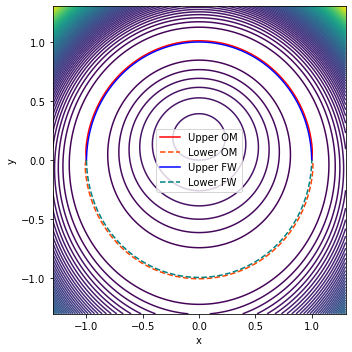

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
X, Y = np.meshgrid(np.linspace(xlims[0], xlims[1], 400),  np.linspace(ylims[0], ylims[1], 400))
Z = system.compute_potential(X, Y)
#U, V = force_vec(X, Y)
#speed = np.sqrt(U**2 + V**2)
#lw = 6*speed / speed.max() + 0.4
#ax.streamplot(X, Y, U, V, density=[2, 2], linewidth=lw)
ax.contour(X, Y, Z, levels=100)
ax.plot(upper_OM['path'][0,:], upper_OM['path'][1,:], upper_OM_inst_shape, color=upper_OM_inst_color, label='Upper OM')
ax.plot(lower_OM['path'][0,:], lower_OM['path'][1,:], lower_OM_inst_shape, color=lower_OM_inst_color, label='Lower OM')
ax.plot(upper_FW['path'][0,:], upper_FW['path'][1,:], upper_FW_inst_shape, color=upper_FW_inst_color, label='Upper FW')
ax.plot(lower_FW['path'][0,:], lower_FW['path'][1,:], lower_FW_inst_shape, color=lower_FW_inst_color, label='Lower FW')
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

### Teleporters

In [27]:
teleporters = []
teleporters_valid_mask = []
teleporters_labels = []

if teleporter_choice == 'OM':
    for l in range(len(upper_OMs)):
        teleporters_labels.append('upper_OM_%s' % l)
    for l in range(len(lower_OMs)):
        teleporters_labels.append('lower_OM_%s' % l)
    
    for inst in upper_OMs + lower_OMs:
        teleporters_valid_mask.append(inst['is_valid'])
        if inst['is_valid']:
            teleporters.append(inst['teleporter'])
elif teleporter_choice == 'FW':
    for l in range(len(upper_OMs)):
        teleporters_labels.append('upper_FW_%s' % l)
    for l in range(len(lower_OMs)):
        teleporters_labels.append('lower_FW_%s' % l)
    
    for inst in upper_FWs + lower_FWs:
        teleporters_valid_mask.append(inst['is_valid'])
        if inst['is_valid']:
            teleporters.append(inst['teleporter'])
else:
    raise Exception('Poor teleporter choice')
    
#if not upper_teleporter_inst['is_valid'] and lower_teleporter_inst['is_valid']:
#    use_teleport = False
#    MCMC_params['use_teleport'] = use_teleport
#else:
#    MCMC_params['teleporters'] = [upper_teleporter_inst['teleporter'], lower_teleporter_inst['teleporter']]

MCMC_params['teleporters'] = teleporters

if MCMC_params['teleporter_probs'] == 'uniform':
    MCMC_params['teleporter_probs'] = [1]*len(teleporters)
else:
    MCMC_params['teleporter_probs'] = np.array(MCMC_params['teleporter_probs'])[teleporters_valid_mask]
    
teleporters_labels = np.array(teleporters_labels)[teleporters_valid_mask]

If the instantons are not valid, use flips instead

In [28]:
#if not upper_teleporter_inst['is_valid'] or not lower_teleporter_inst['is_valid']:
#    MCMC_params['p_teleport'] = 0
#    sim_result.log('Using flip')
#elif system_params['beta'] > MCMC_params['flip_beta_threshold']:
#    MCMC_params['p_flip'] = 0
#    sim_result.log('Using teleport')
#else:
#    sim_result.log('Using teleport and flip')

if system_params['beta'] <= MCMC_params['flip_beta_threshold']:
    sim_result.log('Using teleport and flip')
else:
    MCMC_params['p_flip'] = 0
    sim_result.log('Using teleport')

Using teleport and flip


### Find kappa

Find the baseline kappa

In [29]:
sim_result.log('Finding baseline kappa')

kappa_finder_params['MCMC_params'] = dict.copy(MCMC_params) # Important that we copy MCMC_params here after state0 has been set
kappa_finder_params['MCMC_params']['FFTW_planner_flag'] = 'FFTW_MEASURE'
kappa_finder_params['MCMC_params']['p_teleport'] = kappa_finder_params['p_teleport']
_kappa_finder_params = dict.copy(kappa_finder_params)
del _kappa_finder_params['p_teleport']
kappa_finder_res = modemc.utils.find_kappa(**_kappa_finder_params)
baseline_kappa = kappa_finder_res[0]

sim_result.log('Baseline kappa:', baseline_kappa)

Finding baseline kappa
Baseline kappa: 0.05873846978162804


Find the Gaussian cutoff point

In [30]:
sim_result.log('Finding Gaussian cut-off')

window_MCMC_params = dict.copy(MCMC_params)
window_MCMC_params['use_teleport'] = gaussian_mode_finder_use_teleport
window_MCMC_params['p_teleport'] = gaussian_mode_finder_p_teleport
window_MCMC_params['use_windows'] = True

find_gaussian_N_sim = Nm*gaussian_mode_finder_N_step_Nm_factor
window_MCMC_params['Nm_save'] = 0
window_MCMC_params['window_probs'] = np.full(Nm, 1)
window_MCMC_params['window_indices'] = np.arange(0, Nm)
window_MCMC_params['kappa'] = gaussian_mode_finder_params['kappa']

window_sim = modemc.protocols.pCN(window_MCMC_params)
window_sim.simulate(N_steps=find_gaussian_N_sim, batch_size=batch_size, N_save=0, N_paths_save=0, use_GB=True, verbose=True);

Finding Gaussian cut-off


In [31]:
window_sim.window_attempt_counts[window_sim.window_attempt_counts == 0] = 1
window_acc_rates = window_sim.window_acceptance_counts / window_sim.window_attempt_counts

w = np.where(window_acc_rates > gaussian_mode_finder_params['gaussian_mode_acc_threshold'])[0]
if len(w) != 0:
    gaussian_mode_k = w[0]
else:
    gaussian_mode_k = 10*Nm
    
gaussian_mode_k = int(np.round(gaussian_mode_k * gaussian_mode_finder_params['gaussian_mode_multiplier']))
    
sim_result.log('gaussian_mode_k:', gaussian_mode_k)

gaussian_mode_k: 166


In [32]:
del window_sim

Construct the kappa vector

In [33]:
def sigmoid(x, xmin, xmax, mu, sig):
    return xmin + (xmax - xmin) / (1 + np.exp(-sig*(x-mu)))

ms = np.arange(0, Nm)
kappas = sigmoid(ms, baseline_kappa, 1, gaussian_mode_k, gaussian_mode_finder_params['kappas_sig'])
MCMC_params['kappa'] = kappas

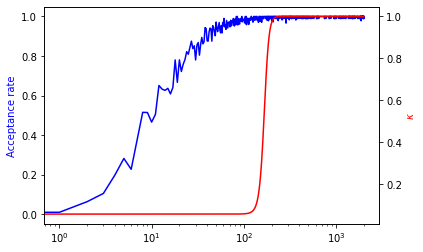

In [34]:
fig,ax = plt.subplots()

ax.plot(ms, window_acc_rates, color="blue")
ax.set_ylabel("Acceptance rate", color="blue")

ax2 = ax.twinx()
ax2.plot(ms, kappas, color='red')
ax2.set_xlabel("Mode")
ax2.set_ylabel(r'$\kappa$', color="red")

plt.xscale('log')
plt.show()

In [35]:
results['baseline_kappa'] = baseline_kappa
results['kappas'] = kappas
results['gaussian_mode_k'] = gaussian_mode_k
results['window_acc_rates'] = window_acc_rates

### Free up memory

We save the calibration results to free them from memory.

In [36]:
keys_to_store = ['S', 'Z_sign_OM', 'log_Z_OM', 'Z_sign_FW', 'log_Z_FW', 'is_valid']
for inst_k in ['upper_OM', 'lower_OM', 'upper_FW', 'lower_FW']:
    for ks in keys_to_store:
        for l, inst in enumerate(results['%s_loop_instantons' % inst_k]):
            calcs['%s_loop%s_%s' % (inst_k, l, ks)] = inst[ks]
        
for inst_k in ['upper_OM', 'lower_OM', 'upper_FW', 'lower_FW']:
    for l, inst in enumerate(results['%s_loop_instantons' % inst_k]):
        sim_result.log('%s loop %s:' % (inst_k, l), log_name='results', print_time=False)

        det_Q_sign_OM, log_det_Q_OM = np.linalg.slogdet(inst['Qf_OM'])
        det_Q_sign_FW, log_det_Q_FW = np.linalg.slogdet(inst['Qf_FW'])

        sim_result.log('  %s: %s' % ('S0', inst['S0']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('S', inst['S']), log_name='results', print_time=False)

        sim_result.log('  %s: %s' % ('end_status', inst['end_status']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('end_step', inst['end_step']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('dS', inst['dS']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('|gradS|', inst['|gradS|']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('step_size', inst['step_size']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('is_valid', inst['is_valid']), log_name='results', print_time=False)

        sim_result.log('  %s: %s' % ('Z_sign_OM', inst['Z_sign_OM']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('log_Z_OM', inst['log_Z_OM']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('Z_sign_FW', inst['Z_sign_FW']), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('log_Z_FW', inst['log_Z_FW']), log_name='results', print_time=False)

        sim_result.log('  %s: %s' % ('det_Q_sign_OM', det_Q_sign_OM), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('log_det_Q_OM', log_det_Q_OM), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('det_Q_sign_FW', det_Q_sign_FW), log_name='results', print_time=False)
        sim_result.log('  %s: %s' % ('log_det_Q_FW', log_det_Q_FW), log_name='results', print_time=False)

        sim_result.log('', log_name='results', print_time=False)

upper_OM loop 0:
  S0: -35.12194518263978
  S: -36.859268740434786
  end_status: S_tol
  end_step: 7067
  dS: 0.0
  |gradS|: 3.437536470577463e-05
  step_size: 7.346317954724022e-05
  is_valid: True
  Z_sign_OM: 1
  log_Z_OM: -108.11899637801089
  Z_sign_FW: 1
  log_Z_FW: -111.61667337618731
  det_Q_sign_OM: 1.0
  log_det_Q_OM: 400.0256993969563
  det_Q_sign_FW: 1.0
  log_det_Q_FW: 407.02105339330916

upper_OM loop 1:
  S0: 71.21398472102406
  S: 69.70498507144582
  end_status: S_tol
  end_step: 5825
  dS: 0.0
  |gradS|: 0.0004444863252371733
  step_size: 0.00024538407216723515
  is_valid: True
  Z_sign_OM: 1
  log_Z_OM: -98.8675180320822
  Z_sign_FW: 1
  log_Z_FW: -102.2804423680602
  det_Q_sign_OM: 1.0
  log_det_Q_OM: 381.52274270509895
  det_Q_sign_FW: 1.0
  log_det_Q_FW: 388.34859137705496

lower_OM loop 0:
  S0: -12.203633620255895
  S: -13.37792574679001
  end_status: gradS_tol
  end_step: 1355
  dS: 0.0
  |gradS|: 9.915583151102545e-06
  step_size: 0.0005538543957847917
  is_val

In [37]:
del_keys = ['Q_OM', 'Qf_OM', 'Q_FW', 'Qf_FW', 'teleporter']

for inst in upper_OMs + lower_OMs + upper_FWs + lower_FWs:
    for k in del_keys:
        del inst[k]
        
sim_result.save_pkl('results', results)
del results

## 3. Define observables

In [38]:
observables = {
    'accept_rate' : [],
    'avg_upper_channel_residency' : [],
    'upper_channel_path_rate' : [],
    'coeffy0' : [],
    'pos_coeffy0' : [],
    'winding_number' : [],
    'clock_winding_number' : [],
    'aclock_winding_number' : []
}

trace_observables = { k : [] for k in observables }

Accept rate

In [39]:
accept_count = 0
accept_N = 0

def compute_accept_rate(batch_states, batch_accepts, batch_actions, batch_paths, batch_d_paths):
    global accept_count, accept_N
    
    M = batch_states.shape[0] # int(np.ceil(batch_states.shape[0] / N_trace_observable))
    N_trace_observable = 1
    for i in range(M):
        _batch_accepts = batch_accepts[i*N_trace_observable:(i+1)*N_trace_observable]
        accept_count += np.count_nonzero(_batch_accepts)
        accept_N += len(_batch_accepts)
        
        trace_observables['accept_rate'].append(accept_count/accept_N)
        #trace_observables['steps'].append(accept_N)
        
    for i in range(batch_states.shape[0]):
        observables['accept_rate'].append(batch_accepts[i])

Measure the channel rates

In [40]:
upper_channel_time = 0
upper_channel_total = 0
upper_channel_paths_count = 0
mean_coeffy0 = 0
pos_coeffy0_count = 0

def compute_channel_rates(batch_states, batch_accepts, batch_actions, batch_paths, batch_d_paths):
    global upper_channel_time, upper_channel_total
    global upper_channel_paths_count
    global pos_coeffy0_count, mean_coeffy0
    
    M = batch_states.shape[0] # int(np.ceil(batch_states.shape[0] / N_trace_observable))
    N_trace_observable = 1
    for i in range(M):
        _batch_paths = batch_paths[i*N_trace_observable:(i+1)*N_trace_observable]
        _batch_states = batch_states[i*N_trace_observable:(i+1)*N_trace_observable]
        
        theta = np.einsum('in,n->i', _batch_paths[:,1,:] > 0, sim.quad_weights) / Tf
        upper_channel_time += np.sum(theta)
        upper_channel_paths_count += np.count_nonzero(theta > 0.5)
        upper_channel_total += len(_batch_paths)
    
        pos_coeffy0_count += np.count_nonzero(_batch_states[:,1,0] > 0)
        mean_coeffy0 = ((upper_channel_total - len(_batch_paths))*mean_coeffy0 + np.sum(_batch_states[:,1,0]))/upper_channel_total
        
        trace_observables['avg_upper_channel_residency'].append(upper_channel_time/upper_channel_total)
        trace_observables['upper_channel_path_rate'].append(upper_channel_paths_count/upper_channel_total)
        trace_observables['coeffy0'].append(mean_coeffy0)
        trace_observables['pos_coeffy0'].append(pos_coeffy0_count/upper_channel_total)
        
    for i in range(batch_states.shape[0]):
        theta = sim.quad_weights.dot(batch_paths[i,1,:] > 0) / Tf
        observables['avg_upper_channel_residency'].append(theta)
        observables['upper_channel_path_rate'].append(theta > 0.5)
        observables['coeffy0'].append(batch_states[i,1,0])
        observables['pos_coeffy0'].append(batch_states[i,1,0] > 0)

Winding number

In [41]:
wn_Nm = Nm_save
wn_Nq = 5*wn_Nm

wn_ts, wn_qts, wn_ws = modemc.quad.clenshaw_curtis(wn_Nq, Tf)

def compute_winding_number(batch_states, batch_accepts, batch_actions, batch_paths, batch_d_paths):
    
    #fd_d_paths = np.gradient(batch_paths, sim.ts, axis=2) # Finite difference usually works better
    
    #path_r2s = batch_paths[:,0,:]**2 + batch_paths[:,1,:]**2
    #dthetas = (batch_paths[:,0,:]*fd_d_paths[:,1,:] - batch_paths[:,1,:]*fd_d_paths[:,0,:]) / path_r2s # (x dy - y dx)/r^2
    #dthetas /= (2 * np.pi)
    #pos_dtheta = dthetas > 0
    
    #winding_numbers = np.einsum('in,n->i', dthetas, sim.quad_weights)
    #clock_winding_numbers = np.einsum('in,n->i', (~pos_dtheta)*dthetas, sim.quad_weights)
    #aclock_winding_numbers = np.einsum('in,n->i', pos_dtheta*dthetas, sim.quad_weights) 
    
    wn_bb_mean, wn_dbb_mean, wn_phis, wn_dphis = modemc.utils.get_fast_eval_path_basis(x0, x1, wn_ts, Tf, wn_Nm)
    wn_paths = np.einsum('lik,kn->lin', batch_states[:,:,:wn_Nm], wn_phis) + wn_bb_mean
    wn_d_paths = np.einsum('lik,kn->lin', batch_states[:,:,:wn_Nm], wn_dphis) + wn_dbb_mean
    
    path_r2s = wn_paths[:,0,:]**2 + wn_paths[:,1,:]**2
    dthetas = (wn_paths[:,0,:]*wn_d_paths[:,1,:] - wn_paths[:,1,:]*wn_d_paths[:,0,:]) / path_r2s # (x dy - y dx)/r^2
    dthetas /= (2 * np.pi)
    pos_dtheta = dthetas > 0
    
    winding_numbers = np.einsum('in,n->i', dthetas, wn_ws)
    clock_winding_numbers = np.einsum('in,n->i', (~pos_dtheta)*dthetas, wn_ws)
    aclock_winding_numbers = np.einsum('in,n->i', pos_dtheta*dthetas, wn_ws) 
    
    for i in range(batch_states.shape[0]):
        observables['winding_number'].append(winding_numbers[i])
        observables['clock_winding_number'].append(clock_winding_numbers[i])
        observables['aclock_winding_number'].append(aclock_winding_numbers[i])

Store observables in harddisk to save RAM

In [42]:
def save_observables():
    for k in observables:
        observables[k] = np.array(observables[k])
    _trace_observables = { 'trace_%s' % k : np.array(trace_observables[k]) for k in trace_observables if len(trace_observables[k]) != 0 }
    
    sim_result.save_data(observables, sample_ratio=1.0)
    sim_result.save_data(_trace_observables, sample_ratio=1.0)
    
    for k in observables:
        observables[k] = []
        trace_observables[k] = []

Register the observables

In [43]:
observables_funcs = {
    'accept_rate' : compute_accept_rate,
    'channel_rates' : compute_channel_rates,
    'winding_number' : compute_winding_number,
}

## 4. Run simulation

In [44]:
def print_time_left(step_i, time_per_step, time_elapsed):
    global accept_count, accept_N
    clear_output(wait=True)
    steps_left = N_steps - sim.steps

    time_left = steps_left * time_per_step
    if time_left < 60:
        time_left_str = '%s secs' % int(np.round(time_left))
    if time_left > 60:
        time_left_str = '%s mins' % np.round(time_left/60, 2)
    if time_left > 60*60:
        time_left_str = '%s hrs' % np.round(time_left/(60*60),2)
    if time_left > 60*60*24:
        time_left_str = '%s days' % np.round(time_left/(60*60*24),2)

    if sim.steps != 0:
        total = 0
        current_accept_count = accept_count + np.count_nonzero(sim.accepts_arr[:step_i])
        current_accept_N = accept_N + step_i + 1
        accept_rate = np.round(current_accept_count / current_accept_N, 4)
    else:
        accept_rate = np.nan

    print('Time Left: %s. Steps %s/%s' % (time_left_str, "{:.2e}".format(sim.steps), "{:.2e}".format(N_steps)))
    
    for k, v in trace_observables.items():
        if k == 'steps':
            continue
        if len(v) > 0:
            print(' %s=%s' % (k, v[-1]))
        
    if sim.steps != 0:
        teleportation_rate = sim.teleportation_count / sim.steps
    else:
        teleportation_rate = np.nan
    if sim.teleportation_attempts != 0:
        teleporation_success_rate = sim.teleportation_count / sim.teleportation_attempts
    else:
        teleporation_success_rate = np.nan
        
    print(' %s=%s' % ('t_rate', teleportation_rate))
    print(' %s=%s' % ('t_succ_rate', teleporation_success_rate))
    print(flush=True)

In [45]:
sim = MCMC_protocol(MCMC_params)

In [46]:
# There is a bug somewhere in pyfftw that causes the dct to malfunction seemingly by random. We re-initialise it until it works

state = np.zeros((system_params['dim'], MCMC_params['Nm']))
state[:, :] = np.random.normal(0, size=state.shape[0]*state.shape[1]).reshape(state.shape)

real_path, real_d_path = modemc.utils.eval_path(system_params['x0'], system_params['x1'], sim.ts, system_params['Tf'], state)
fft_path, fft_d_path = sim.FFT_compute_path_and_dpath(state)

attempts = 0
max_attempts = int(1e4)

while not (np.allclose(fft_path, real_path) and np.allclose(fft_d_path, real_d_path)):
    pyfftw.forget_wisdom()
    sim = MCMC_protocol(MCMC_params)

    fft_path, fft_d_path = sim.FFT_compute_path_and_dpath(state)

    attempts += 1
    
    if attempts > max_attempts:
        raise Exception('Getting the correct DCT failed.')
        
    if attempts % 100 == 0:
        print('FFTW attempt:', attempts)
        
print('FFTW re-initialisations required:', attempts)

FFTW re-initialisations required: 0


In [47]:
N_batch = min(modemc.utils.get_N_steps_to_match_batch_size(sim.Nm_save, sim.Nq, sim.dim, batch_size), N_steps)
batches = int(np.ceil(float(N_steps) / N_batch))
state_save_ratio = min(N_save/float(N_steps), 1.0)
path_save_ratio = min(N_paths_save/float(N_steps), 1.0)
real_batch_size = np.round(modemc.utils.get_batch_size(sim.Nm_save, sim.Nq, sim.dim, N_batch),2)
steps_per_batch = int(np.round(N_steps/batches))

N_steps_left = N_steps

sim_result.log('Batches:', batches)
sim_result.log('Batch size: %s gb' % real_batch_size)
sim_result.log('Steps per batch:', steps_per_batch)

Batches: 65
Batch size: 1.0 gb
Steps per batch: 15385


In [48]:
#full_states = []
#prev_full_states = []
#current_states = []

In [49]:
observables_computing_time = 0
saving_time = 0

import pstats, cProfile

def foo():
    sim.simulate_batch(1000, event_func=print_time_left, N_event=N_sim_verbose)

import pyximport
pyximport.install()

cProfile.runctx("foo()", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

In [50]:
sim_result.log('Starting simulation')

sim_time_start = time.time()

accept_count = 0

N_steps_left = N_steps
_N_batch = N_batch

for i in range(batches):
    if _N_batch > N_steps_left:
        _N_batch = N_steps_left
    
    batch_states, batch_accepts, batch_actions, batch_paths, batch_d_paths = sim.simulate_batch(_N_batch, event_func=print_time_left, N_event=N_sim_verbose)

    #full_states.append(np.copy(sim.full_state_arr))
    #prev_full_states.append(np.copy(sim.prev_full_state_arr))
    #current_states.append(np.copy(sim.current_state))
    
    obs_t_start = time.time()
    for compute_observable_func in observables_funcs.values():
        compute_observable_func(batch_states, batch_accepts, batch_actions, batch_paths, batch_d_paths)
    observables_computing_time += time.time() - obs_t_start
    
    save_observables()
    
    saving_time_start = time.time()
    sim_result.save_data({
        'states' : sim.states_arr,
        'accepts' : sim.accepts_arr,
        'actions' : sim.actions_arr,
    }, sample_ratio=state_save_ratio)
    
    sim_result.save_data({
        'paths' : sim.paths_arr,
        'd_paths' : sim.d_paths_arr,
    }, sample_ratio=path_save_ratio)
    saving_time += time.time() - saving_time_start
    
    N_steps_left -= _N_batch
    
sim_time_end = time.time()
sim_time = sim_time_end - sim_time_start

Time Left: 0 secs. Steps 1.00e+06/1.00e+06
 t_rate=0.0
 t_succ_rate=nan



In [51]:
#sim_result.save_data({
#    'full_states' : np.array(full_states),
#    'prev_full_states' : np.array(prev_full_states),
#    'current_states' : np.array(current_states),
#}, sample_ratio=1.0)

In [52]:
sim_states['sim_time'] = sim_time/(60*60)
sim_states['observables_computation_time'] = observables_computing_time/(60*60)
sim_states['observables_computation_time_ratio'] = observables_computing_time/sim_time

if not sim.window_acceptance_counts is None:
    sim_states['window_acceptance_counts'] = sim.window_acceptance_counts
    sim_states['window_attempt_counts'] = sim.window_attempt_counts
    _window_attempt_counts = np.copy(sim.window_attempt_counts); _window_attempt_counts[_window_attempt_counts==0] = 1
    sim_states['window_acceptance_rates'] = sim.window_acceptance_counts / _window_attempt_counts

if not sim.teleportation_attempts is None:
    sim_states['teleportation_attempts'] = sim.teleportation_attempts
    sim_states['teleportation_count'] = sim.teleportation_count
    sim_states['teleportation_rate'] = sim.teleportation_count / N_steps
    
for k, v in sim_states.items():
    sim_result.log('%s: %s' % (k, v), log_name='sim_states')

sim_time: 0.2958255933390723
observables_computation_time: 0.010757057203186883
observables_computation_time_ratio: 0.036362834877701915
teleportation_attempts: 0
teleportation_count: 0
teleportation_rate: 0.0


## 5. Analysis

### Compute autocorrelation

In [53]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_new(y, c=5.0):
    f = autocorr_func_1d(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [54]:
sim_steps = np.arange(0, N_steps)
N_steps_wo_burnin = N_steps - N_burn_in
sim_steps_wo_burnin = np.arange(N_burn_in, N_steps)

In [55]:
for obs_k in observables:
    if obs_k == 'steps':
        continue
    obs = sim_result.load_random_sample(1.0, [obs_k])
    
    observables_autocorrelation_func = autocorr_func_1d(obs[N_burn_in:])
    sim_result.save_data({'acf_%s' % obs_k : observables_autocorrelation_func}, sample_ratio=1.0)

    tau = autocorr_new(obs[N_burn_in:])
    calcs['tau_' + obs_k] = tau
    calcs['var_' + obs_k] = (tau / N_steps_wo_burnin) * np.var(obs[N_burn_in:])
    
    calcs[obs_k + '_with_burn_in'] = np.mean(obs)
    calcs[obs_k] = np.mean(obs[N_burn_in:])
    
    del obs, observables_autocorrelation_func

/tmp/ipykernel_760220/3964693316.py:20: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


### Misc

In [56]:
def compute_semi_analytical_channel_rate(upper_inst, lower_inst, use_OM):
    if use_OM:
        postfix = 'OM'
    else:
        postfix = 'FW'
    
    if upper_inst['is_valid'] and lower_inst['is_valid']:
        dS = upper_inst['S'] - lower_inst['S']
        dQ = lower_inst['log_Z_%s' % postfix] - upper_inst['log_Z_%s' % postfix]
        Q_channel_rate = 1 / (1 + np.exp(dQ+dS))
        inst_channel_rate = 1 / (1 + np.exp(dS))
    elif not upper_inst['is_valid'] or not lower_inst['is_valid']:
        Q_channel_rate = np.nan
        inst_channel_rate = np.nan
        
    return Q_channel_rate, inst_channel_rate

calcs['Q_OM_channel_rate'], calcs['inst_OM_channel_rate'] = compute_semi_analytical_channel_rate(upper_OM, lower_OM, True)
calcs['Q_FW_channel_rate'], calcs['inst_FW_channel_rate'] = compute_semi_analytical_channel_rate(upper_OM, lower_OM, False)

In [57]:
sim_states['sim_time'] = sim_time/(60*60)

if not sim.window_acceptance_counts is None:
    sim_states['window_acceptance_counts'] = sim.window_acceptance_counts
    sim_states['window_attempt_counts'] = sim.window_attempt_counts
    _window_attempt_counts = np.copy(sim.window_attempt_counts); _window_attempt_counts[_window_attempt_counts==0] = 1
    sim_states['window_acceptance_rates'] = sim.window_acceptance_counts / _window_attempt_counts

if not sim.teleportation_attempts is None:
    sim_states['use_teleport'] = MCMC_params['use_teleport']
    
    sim_states['teleporters_labels'] = teleporters_labels
    sim_states['teleportation_attempts'] = sim.teleportation_attempts
    sim_states['teleportation_count'] = sim.teleportation_count
    sim_states['teleportation_rate'] = sim.teleportation_count / N_steps
    sim_states['teleporter_attempts'] = sim.teleporter_attempts
    sim_states['teleporter_count'] = sim.teleporter_count
    
    _teleporter_attempts = np.copy(sim.teleporter_attempts)
    _teleporter_attempts[_teleporter_attempts==0] = 1
    sim_states['teleporter_success_rate'] = sim.teleporter_count / _teleporter_attempts
    sim_states['teleporter_rate'] = sim.teleporter_count / N_steps
    
    sim_states['flip_attempts'] = sim.flip_attempts
    sim_states['flip_count'] = sim.flip_count
    _flip_attempts = sim.flip_attempts
    if _flip_attempts == 0:
        _flip_attempts = 1
    sim_states['flip_success_rate'] = sim.flip_count / _flip_attempts
    sim_states['flip_rate'] = sim.flip_count / N_steps
    
sim_states['N_batch'] = N_batch
sim_states['batches'] = batches
sim_states['batch_size'] = batch_size

for k, v in sim_states.items():
    sim_result.log('%s: %s' % (k, v), log_name='sim_states', print_time=False)

sim_time: 0.2958255933390723
observables_computation_time: 0.010757057203186883
observables_computation_time_ratio: 0.036362834877701915
teleportation_attempts: 0
teleportation_count: 0
teleportation_rate: 0.0
use_teleport: True
teleporters_labels: ['upper_OM_0' 'upper_OM_1' 'lower_OM_0']
teleporter_attempts: [0. 0. 0.]
teleporter_count: [0. 0. 0.]
teleporter_success_rate: [0. 0. 0.]
teleporter_rate: [0. 0. 0.]
flip_attempts: 9972
flip_count: 0
flip_success_rate: 0.0
flip_rate: 0.0
N_batch: 15482
batches: 65
batch_size: 1


In [58]:
for k, v in calcs.items():
    sim_result.log('%s: %s' % (k, v), log_name='calcs', print_time=False)

upper_OM_loop0_S: -36.859268740434786
upper_OM_loop1_S: 69.70498507144582
upper_OM_loop0_Z_sign_OM: 1
upper_OM_loop1_Z_sign_OM: 1
upper_OM_loop0_log_Z_OM: -108.11899637801089
upper_OM_loop1_log_Z_OM: -98.8675180320822
upper_OM_loop0_Z_sign_FW: 1
upper_OM_loop1_Z_sign_FW: 1
upper_OM_loop0_log_Z_FW: -111.61667337618731
upper_OM_loop1_log_Z_FW: -102.2804423680602
upper_OM_loop0_is_valid: True
upper_OM_loop1_is_valid: True
lower_OM_loop0_S: -13.37792574679001
lower_OM_loop1_S: 76.65220696271358
lower_OM_loop0_Z_sign_OM: 1
lower_OM_loop1_Z_sign_OM: 1
lower_OM_loop0_log_Z_OM: -89.95876443239099
lower_OM_loop1_log_Z_OM: -92.41785172524207
lower_OM_loop0_Z_sign_FW: 1
lower_OM_loop1_Z_sign_FW: 1
lower_OM_loop0_log_Z_FW: -92.57487210767088
lower_OM_loop1_log_Z_FW: -95.43881928255628
lower_OM_loop0_is_valid: True
lower_OM_loop1_is_valid: False
upper_FW_loop0_S: 12.323409627018085
upper_FW_loop0_Z_sign_OM: 1
upper_FW_loop0_log_Z_OM: -101.57037026099769
upper_FW_loop0_Z_sign_FW: 1
upper_FW_loop0_lo

Check RAM usage

In [59]:
def get_size_of_object(obj, max_depth=4):
    return _get_size_of_object(obj, 0, max_depth)
def _get_size_of_object(obj, depth, max_depth):
    if depth > max_depth:
        return 0
    
    size = sys.getsizeof(obj)
    
    if type(obj) == dict:
        for k, v in obj.items():
            size += _get_size_of_object(v, depth+1, max_depth)
            
    return size

mem_cutoff = 1e6
sim_result.log('RAM usage (cutoff at %sgb):' % (mem_cutoff/1e9))
glbs = dict(globals())
total_usage = 0

for k,v in glbs.items():
    if k[0] == '__' or k in ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1']:
        continue
    if k.startswith('_i'):
        continue
    if k[0] == '_' and k[1] in '0123456789':
        continue
    
    size = get_size_of_object(v)
    
    if size > mem_cutoff:
        sim_result.log('  %s:' % k, np.round(size/1e9, 4), print_time=False)
        
    total_usage += size
    
sim_result.log('  Total:', np.round(total_usage/1e9, 4), print_time=False)

RAM usage (cutoff at 0.001gb):
  X: 0.0013
  Y: 0.0013
  sim_steps: 0.008
  sim_steps_wo_burnin: 0.0056
  Total: 0.0169


## 6. Plots

In [60]:
states, paths, actions, accepts = sim_result.load_random_sample(1.0, ['states', 'paths', 'actions', 'accepts'])

In [61]:
N_obs_data_skip = int(np.floor(max(1.0, N_steps / N_obs_save)))
obs_data_steps = sim_steps[::N_obs_data_skip]
obs_data_steps_wo_burnin = sim_steps_wo_burnin[::N_obs_data_skip]

obs_keys = list(observables.keys())
obs_data = sim_result.load_random_sample(1.0, obs_keys)
_obs_data = [np.copy(obs[::N_obs_data_skip]) for obs in obs_data]
_observables = dict(zip(obs_keys, _obs_data))
_observables['steps'] = obs_data_steps
del obs_data

trace_obs_keys = [ 'trace_%s' % obs_k for obs_k in obs_keys ]
trace_obs_data = sim_result.load_random_sample(1.0, trace_obs_keys)
_trace_obs_data = [np.copy(obs[::N_obs_data_skip]) for obs in trace_obs_data if not obs is None]
_trace_observables = dict(zip(trace_obs_keys, _trace_obs_data))
_trace_observables['steps'] = obs_data_steps
del trace_obs_data

acf_obs_keys = [ 'acf_%s' % obs_k for obs_k in obs_keys ]
acf_obs_data = sim_result.load_random_sample(1.0, acf_obs_keys)
_acf_obs_data = [np.copy(obs[::N_obs_data_skip]) for obs in acf_obs_data]
_acf_observables = dict(zip(acf_obs_keys, _acf_obs_data))
_acf_observables['steps'] = obs_data_steps_wo_burnin
del acf_obs_data

Saving figure trajectories


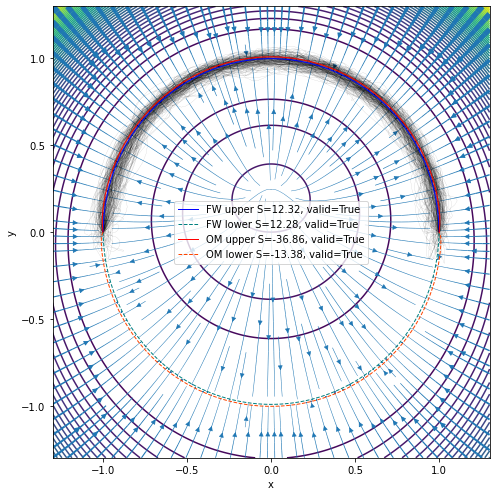

In [62]:
try:
    fig, ax = plt.subplots(figsize=(7,7))
    plotting.trajectories_2D(fig, system, states, xlims, ylims, plot_num=traj_plot_num, plot_potential=True, plot_force=True,
                        contour_levels=50, force_density=[2,2], traj_lw=traj_lw, traj_alpha=traj_alpha, overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    #fig.suptitle(sim_result.result_name)
    plt.legend(loc='center')
    plt.tight_layout()
    sim_result.save_figure(fig, 'trajectories', dpi=400)
    plt.show()
except Exception as e:
    sim_result.log_error('trajectories', e)

Saving figure trajectories_rough


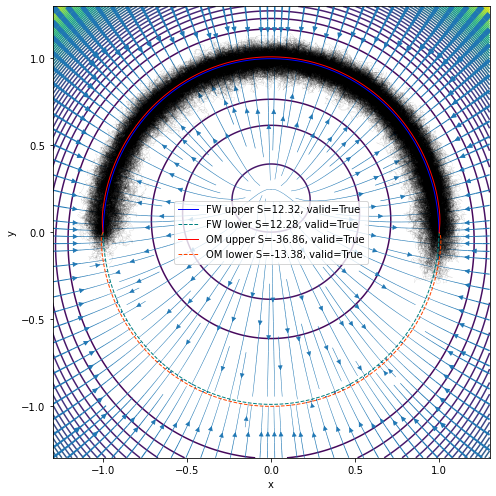

In [63]:
try:
    fig, ax = plt.subplots(figsize=(7,7))
    plotting.trajectories_2D_path(fig, system, sim.ts, paths, xlims, ylims, plot_num=traj_plot_num, plot_potential=True, plot_force=True,
                        contour_levels=50, force_density=[2,2], traj_lw=traj_lw, traj_alpha=traj_alpha, overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    #fig.suptitle(sim_result.result_name)
    plt.legend(loc='center')
    plt.tight_layout()
    sim_result.save_figure(fig, 'trajectories_rough', dpi=400)
    plt.show()
except Exception as e:
    sim_result.log_error('trajectories_rough', e)

Saving figure trajectories_x


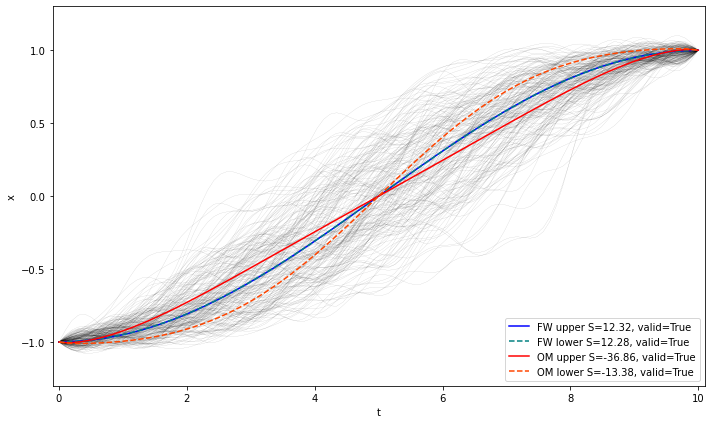

In [64]:
try:
    fig, ax = plt.subplots(figsize=(10,6))
    plotting.trajectories_1D(fig, system, states, tlims, xlims, plot_num=traj_plot_num, plot_dimension=0,
                        extrema=[], traj_lw=traj_lw, traj_alpha=traj_alpha, axes_labels=['t', 'x'], overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    #fig.suptitle(sim_result.result_name)
    plt.legend(loc='lower right')
    plt.tight_layout()
    sim_result.save_figure(fig, 'trajectories_x', dpi=400)
    plt.show()
except Exception as e:
    x = e
    sim_result.log_error('trajectories_x', e)
    sim_result.log(traceback.format_exc(), log_name='error')
    #traceback.print_tb(e.__traceback__)

Saving figure trajectories_y


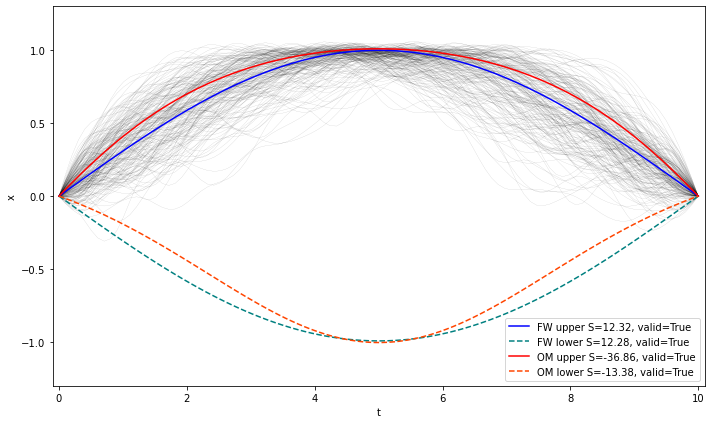

In [65]:
try:
    fig, ax = plt.subplots(figsize=(10,6))
    plotting.trajectories_1D(fig, system, states, tlims, xlims, plot_num=traj_plot_num, plot_dimension=1,
                        extrema=[], traj_lw=traj_lw, traj_alpha=traj_alpha, axes_labels=['t', 'x'], overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    #fig.suptitle(sim_result.result_name)
    plt.legend(loc='lower right')
    plt.tight_layout()
    sim_result.save_figure(fig, 'trajectories_y', dpi=400)
    plt.show()
except Exception as e:
    x = e
    sim_result.log_error('trajectories_y', e)
    sim_result.log(traceback.format_exc(), log_name='error')
    #traceback.print_tb(e.__traceback__)

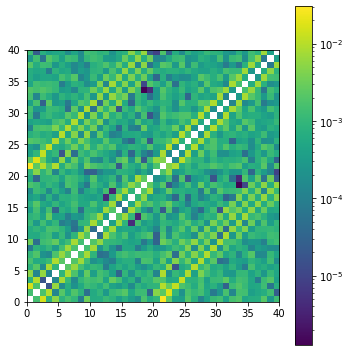

Saving figure abs_covariance


In [66]:
try:
    fig, ax = plt.subplots(figsize=(5, 5))
    covs = plotting.plot_abs_cov_matrix(fig, states, covariance_samples_sum=-1, plot_diagonal=False)
    #fig.suptitle(sim_result.result_name)
    plt.tight_layout()
    plt.show()
    sim_result.save_calculations({
        'covariance' : covs
    })
    sim_result.save_figure(fig, 'abs_covariance', dpi=400)
except Exception as e:
    sim_result.log_error('abs_covs', e)

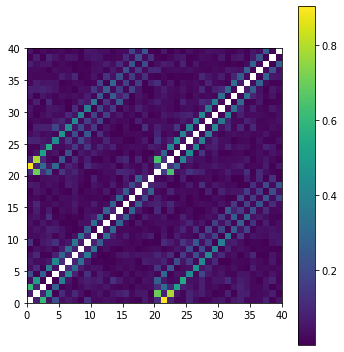

Saving figure corr_coeff


In [67]:
try:
    fig, ax = plt.subplots(figsize=(5, 5))
    corr_coeff = plotting.plot_abs_corr_coeff_matrix(fig, states, covariance_samples_sum=-1, plot_diagonal=False)
    #fig.suptitle(sim_result.result_name)
    plt.tight_layout()
    plt.show()
    sim_result.save_calculations({
        'corr_coeff' : corr_coeff
    })
    sim_result.save_figure(fig, 'corr_coeff', dpi=400)
except Exception as e:
    sim_result.log_error('corr_coeff', e)

Saving figure coeffs


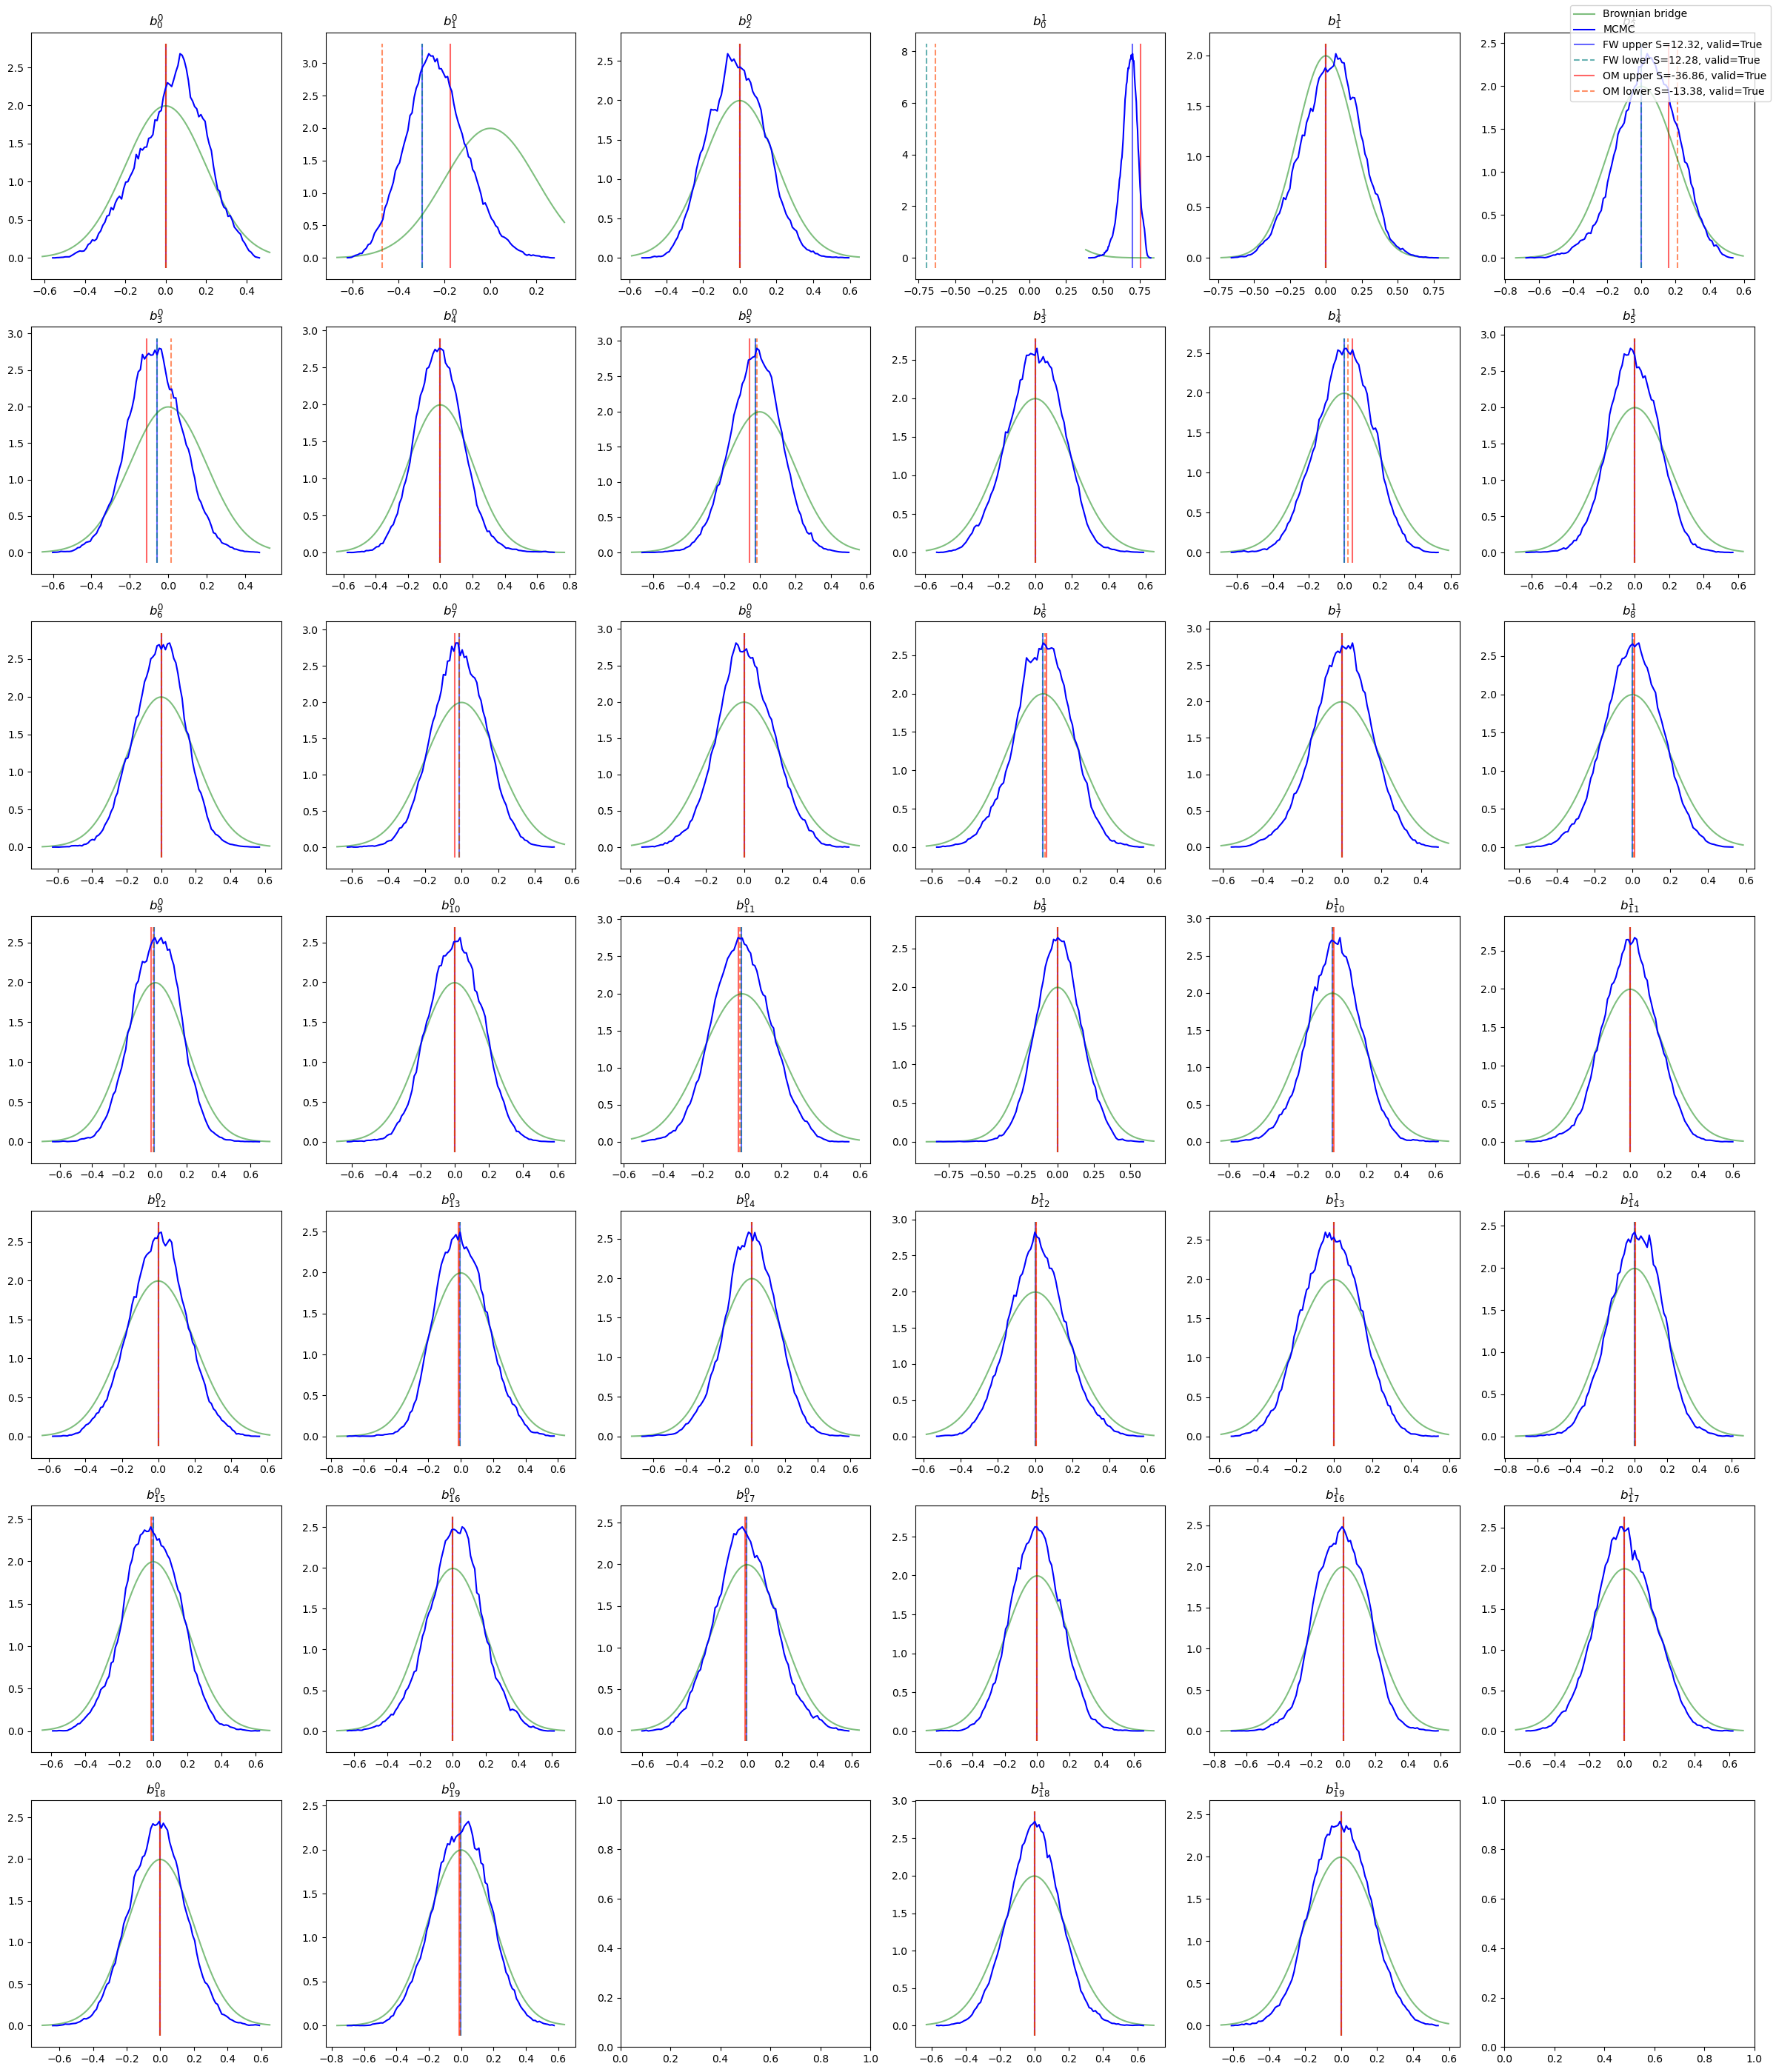

In [68]:
try:
    fig, axes = plotting.mode_distribution(system, states, w_per_dim=3, overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    plt.tight_layout()
    sim_result.save_figure(fig, 'coeffs')
    fig.show()
except Exception as e:
    sim_result.log_error('coeffs', e)

/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/store/SOFT/ltk26/anaconda3/envs/tps/lib/python3.9/site-packages/numpy/lib/histo

Saving figure split_coeffs


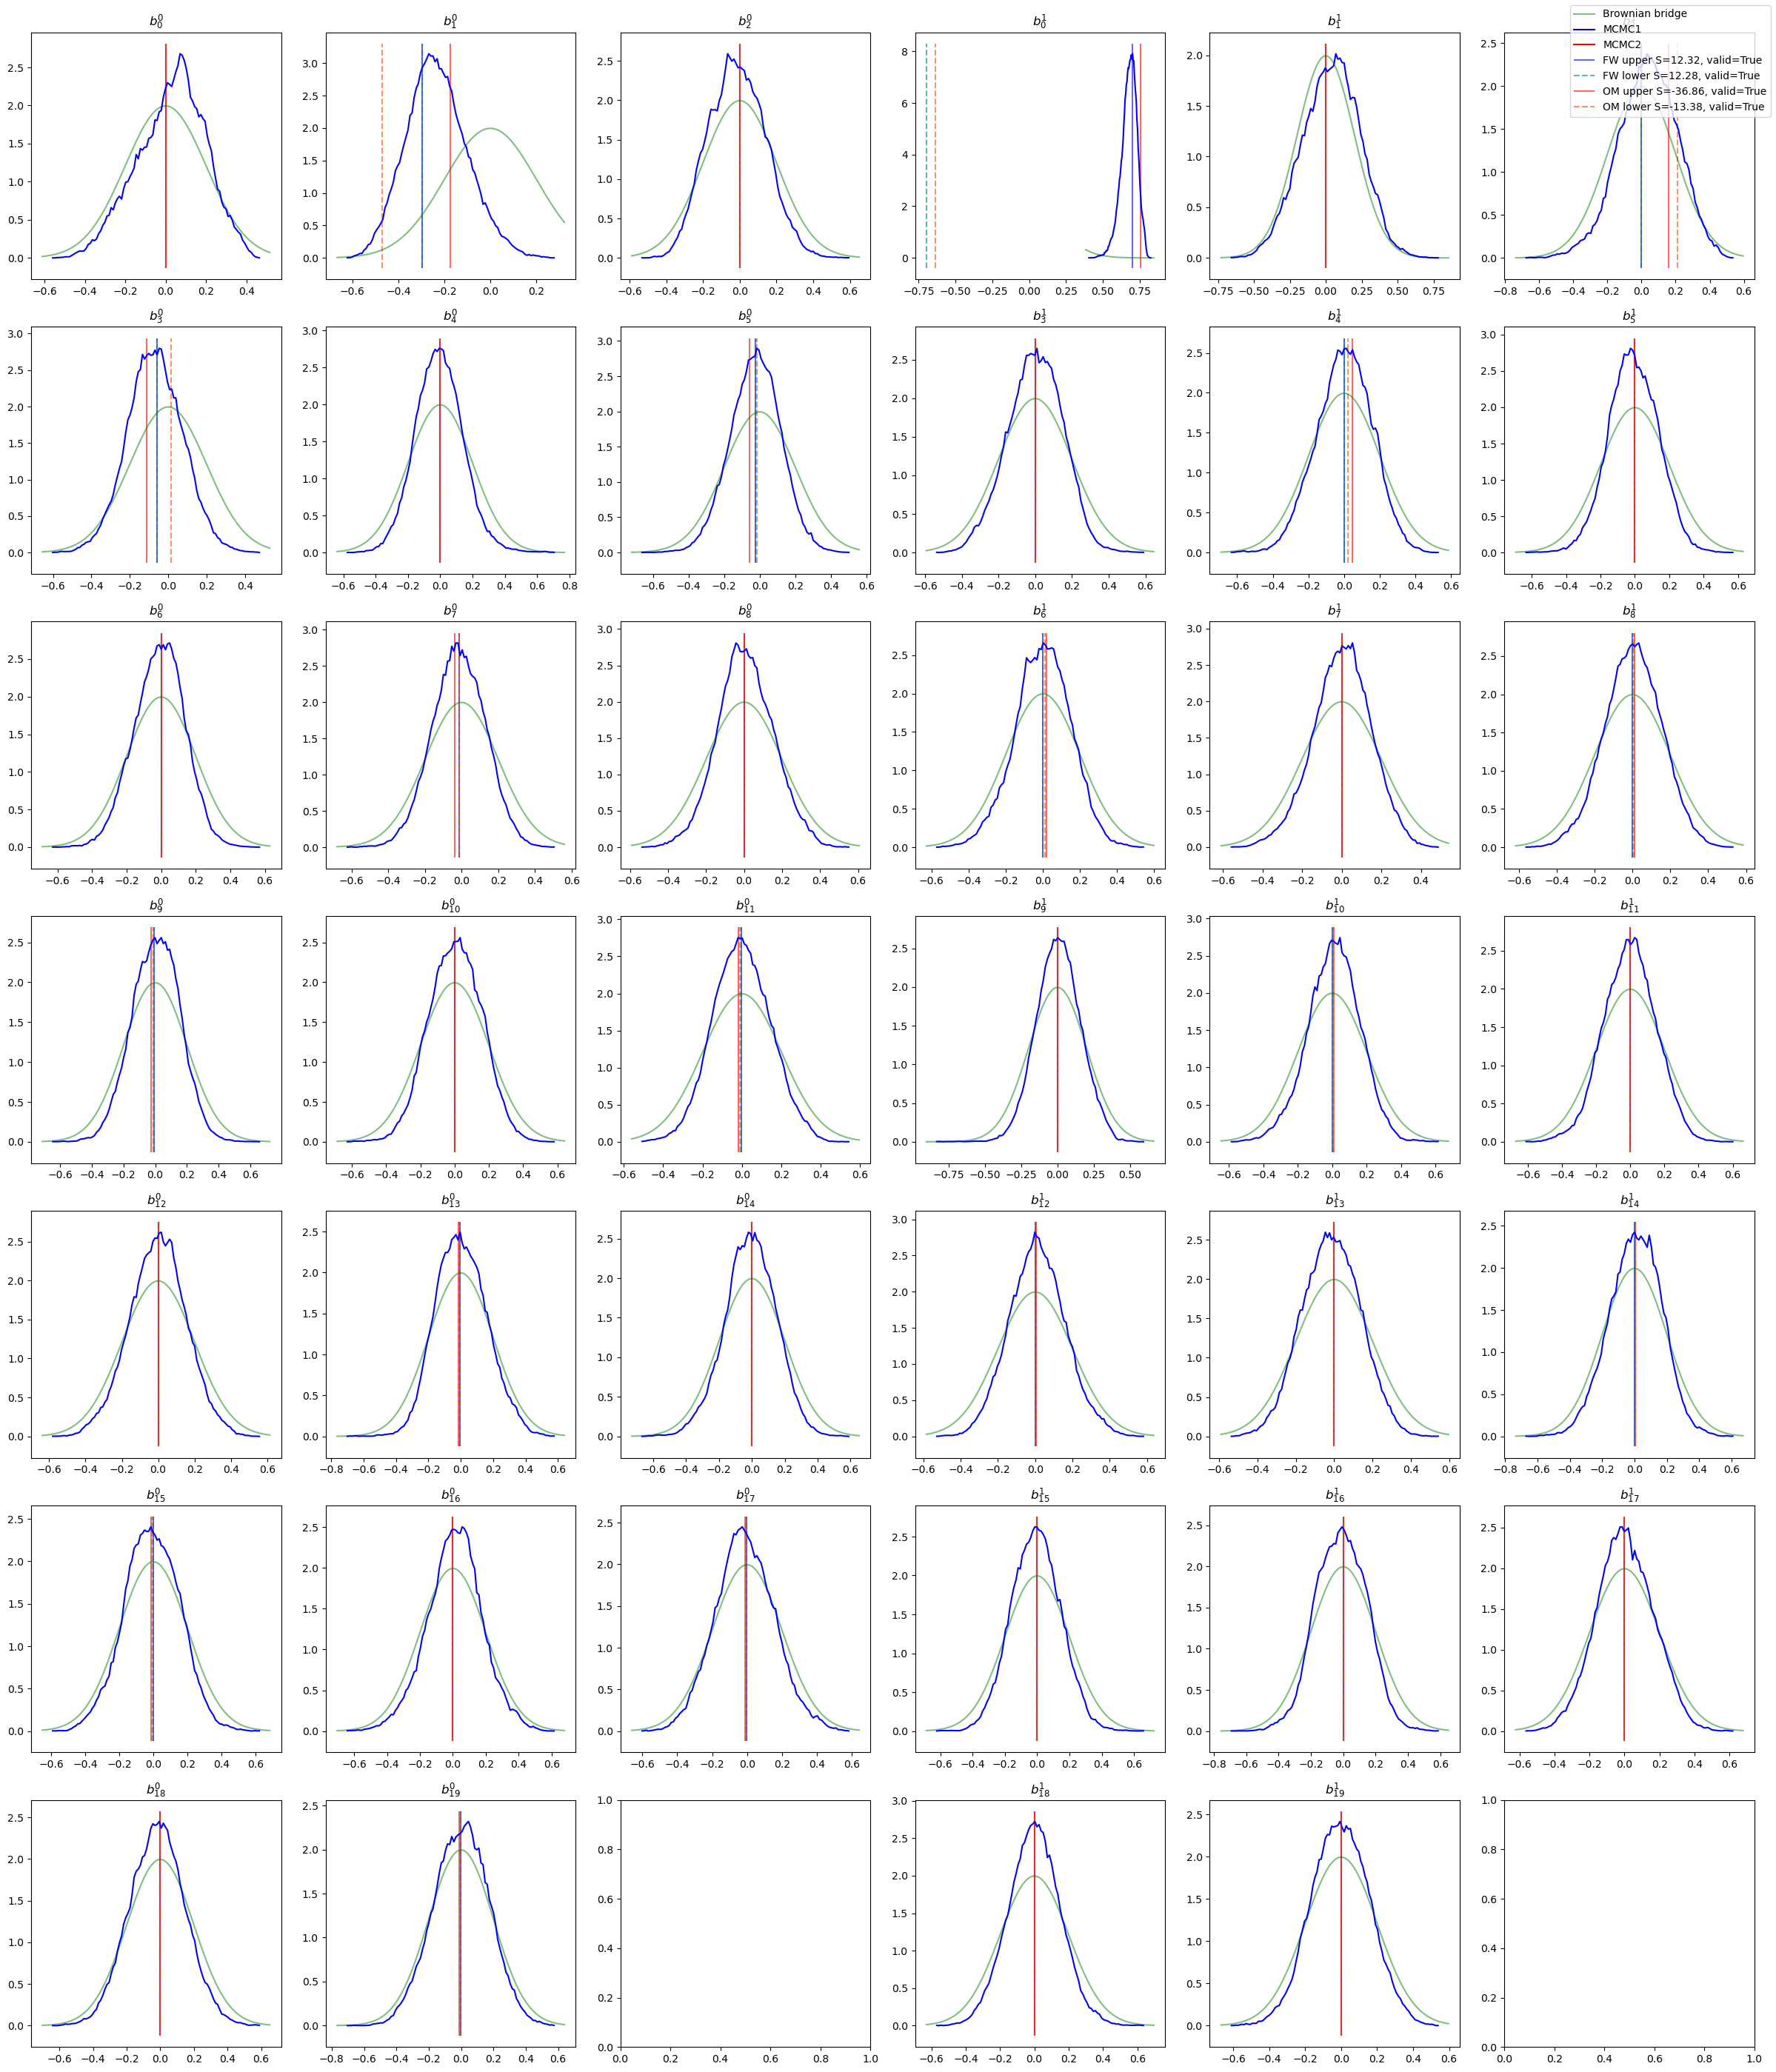

In [69]:
try:
    upper_states_mask = states[:, 1, 0] > 0
    fig, axes = plotting.mode_distribution2(system, states[upper_states_mask], states[~upper_states_mask], w_per_dim=3, overlay_paths=[
        ("FW upper S=%s, valid=%s" % (np.round(upper_FW['S'],2), upper_FW['is_valid']), upper_FW_inst_shape, upper_FW_inst_color, upper_FW['state']),
        ("FW lower S=%s, valid=%s" % (np.round(lower_FW['S'],2), lower_FW['is_valid']), lower_FW_inst_shape, lower_FW_inst_color, lower_FW['state']),       
        ("OM upper S=%s, valid=%s" % (np.round(upper_OM['S'],2), upper_OM['is_valid']), upper_OM_inst_shape, upper_OM_inst_color, upper_OM['state']),
        ("OM lower S=%s, valid=%s" % (np.round(lower_OM['S'],2), lower_OM['is_valid']), lower_OM_inst_shape, lower_OM_inst_color, lower_OM['state']),
    ])
    plt.tight_layout()
    sim_result.save_figure(fig, 'split_coeffs')
    fig.show()
except Exception as e:
    sim_result.log_error('split_coeffs', e)

Saving figure observables


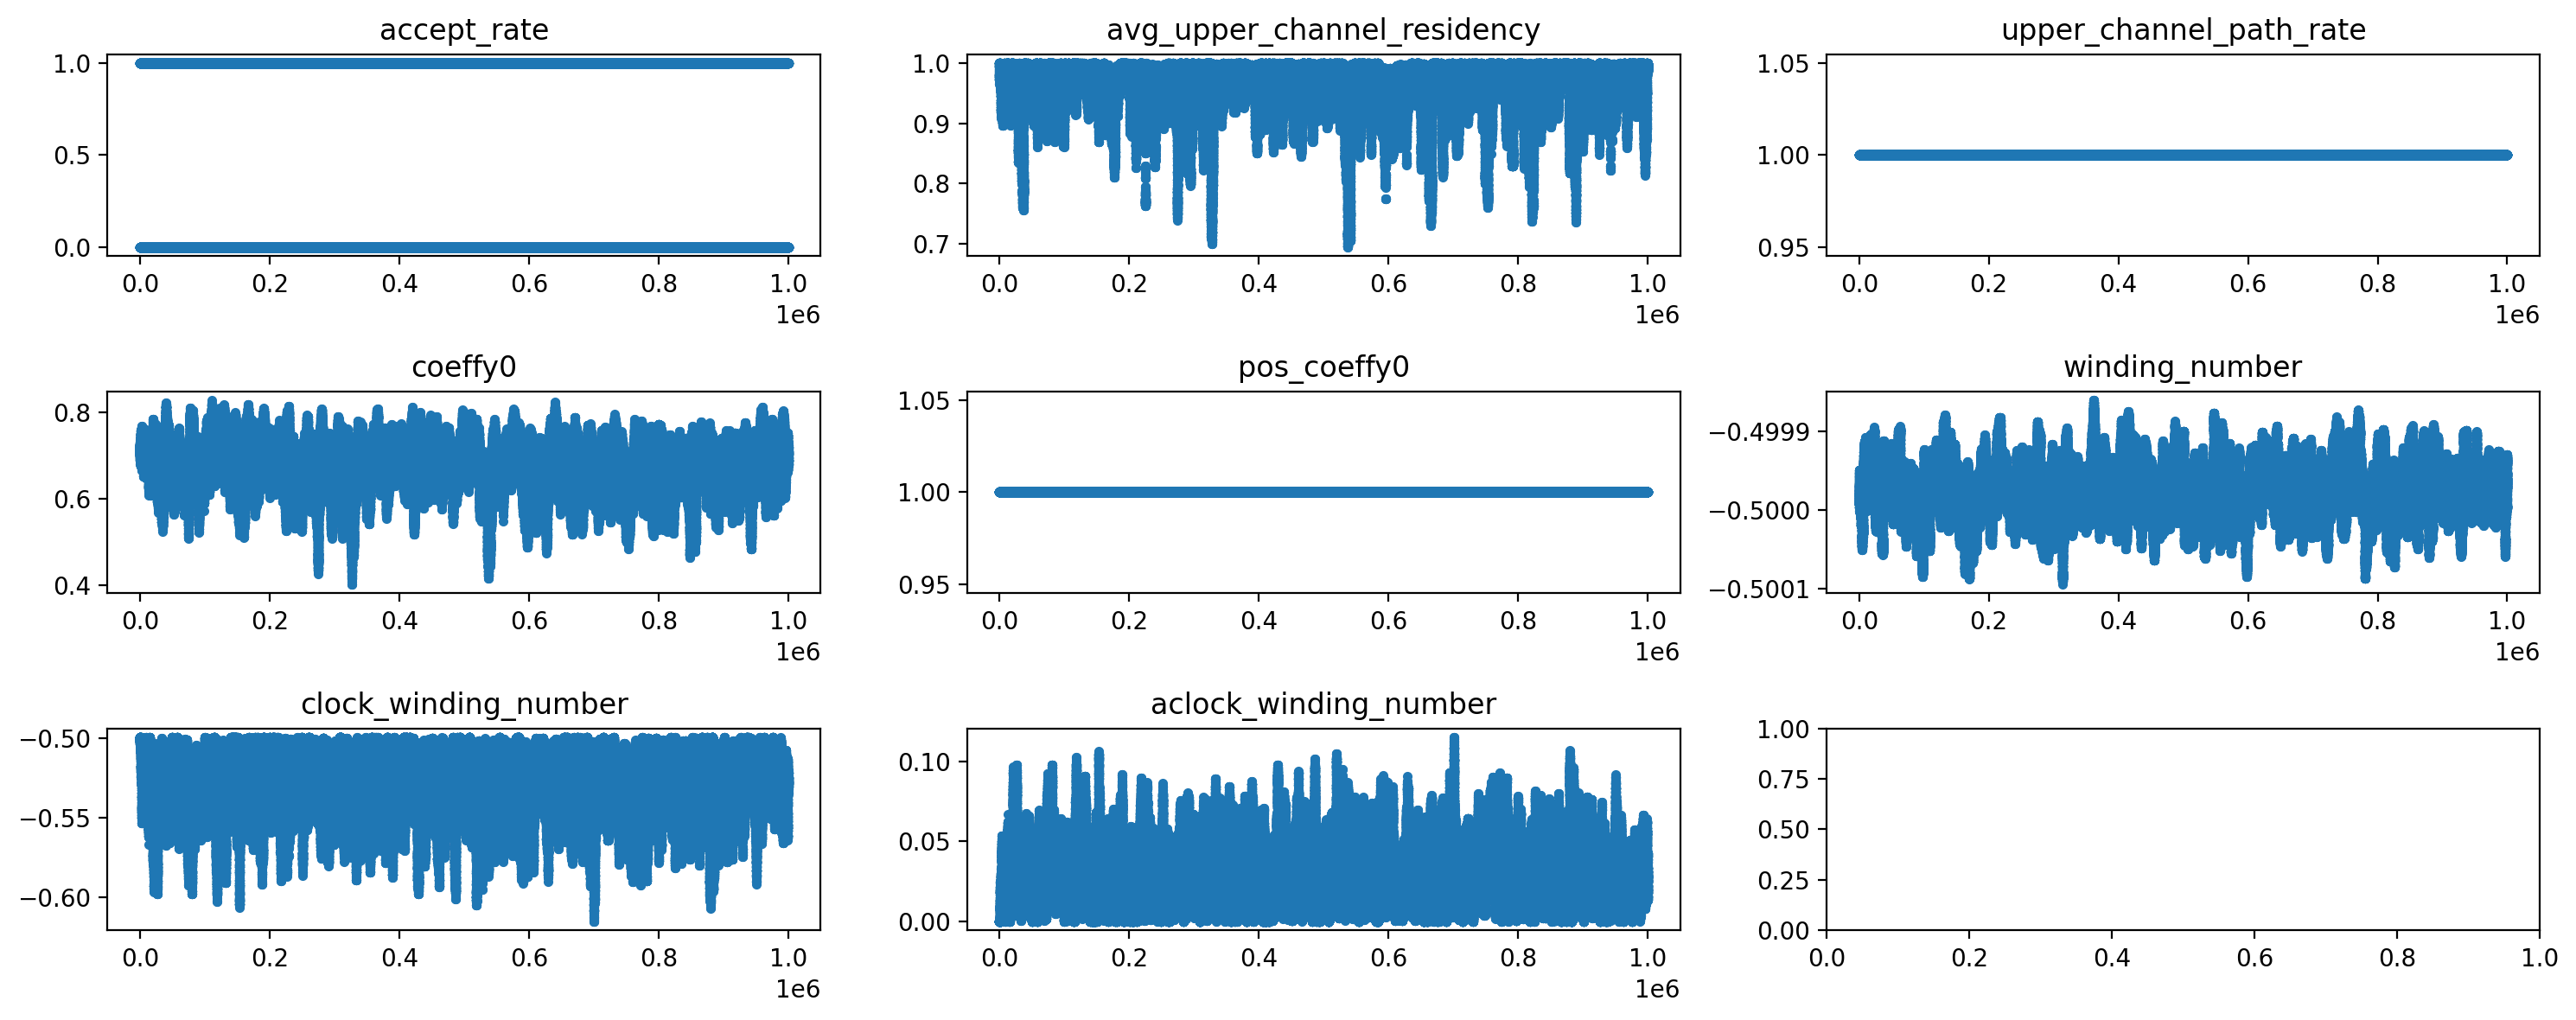

In [70]:
try:
    fig, axes = plotting.plot_time_series(_observables, fmt='.')
    plt.tight_layout()
    sim_result.save_figure(fig, 'observables')
    fig.show()
except Exception as e:
    sim_result.log_error('observables', e)

Saving figure winding_numbers_dist


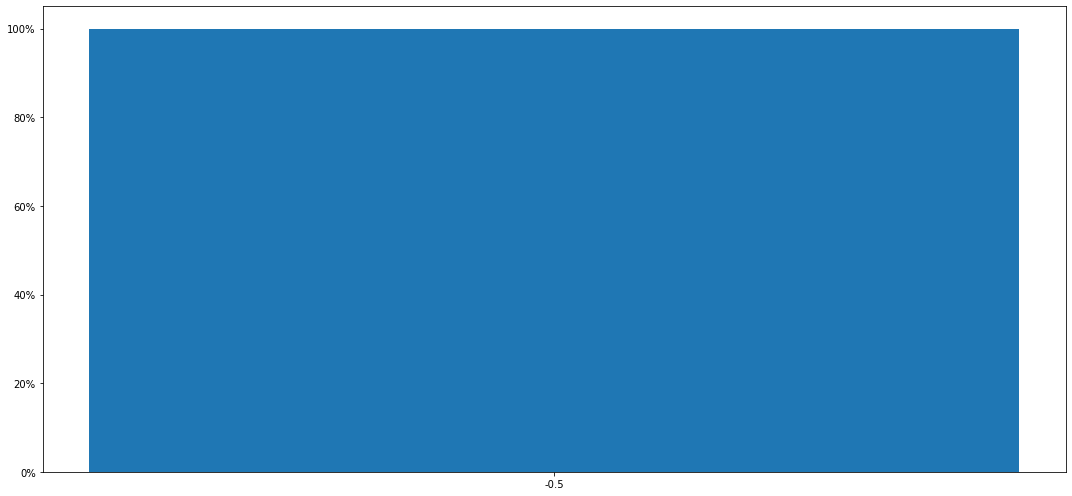

In [71]:
try:
    import matplotlib.ticker as mtick

    obs_winding_numbers = sim_result.load_random_sample(1.0, ['winding_number'])
    
    rounded_wn = np.round(obs_winding_numbers*2)/2
    unique_wn = np.unique(rounded_wn)
    unique_wn.sort()

    wn_count = np.zeros(unique_wn.shape, dtype=int)
    for i in range(len(unique_wn)):
        wn_count[i] = np.count_nonzero(rounded_wn==unique_wn[i])

    wn_perc = wn_count / np.sum(wn_count)
    insignificant_mask = wn_perc > 1e-4

    wn_perc = wn_perc[insignificant_mask]
    unique_wn = unique_wn[insignificant_mask]
    wn_count = wn_count[insignificant_mask]

    fig, ax = plt.subplots(figsize=(15, 7))

    ax.bar([str(l) for l in unique_wn], 100*wn_perc)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

    plt.tight_layout()
    sim_result.save_figure(fig, 'winding_numbers_dist')
    fig.show()
    
    del obs_winding_numbers
    
except Exception as e:
    sim_result.log_error('winding_numbers_dist', e)

Saving figure acf_observables


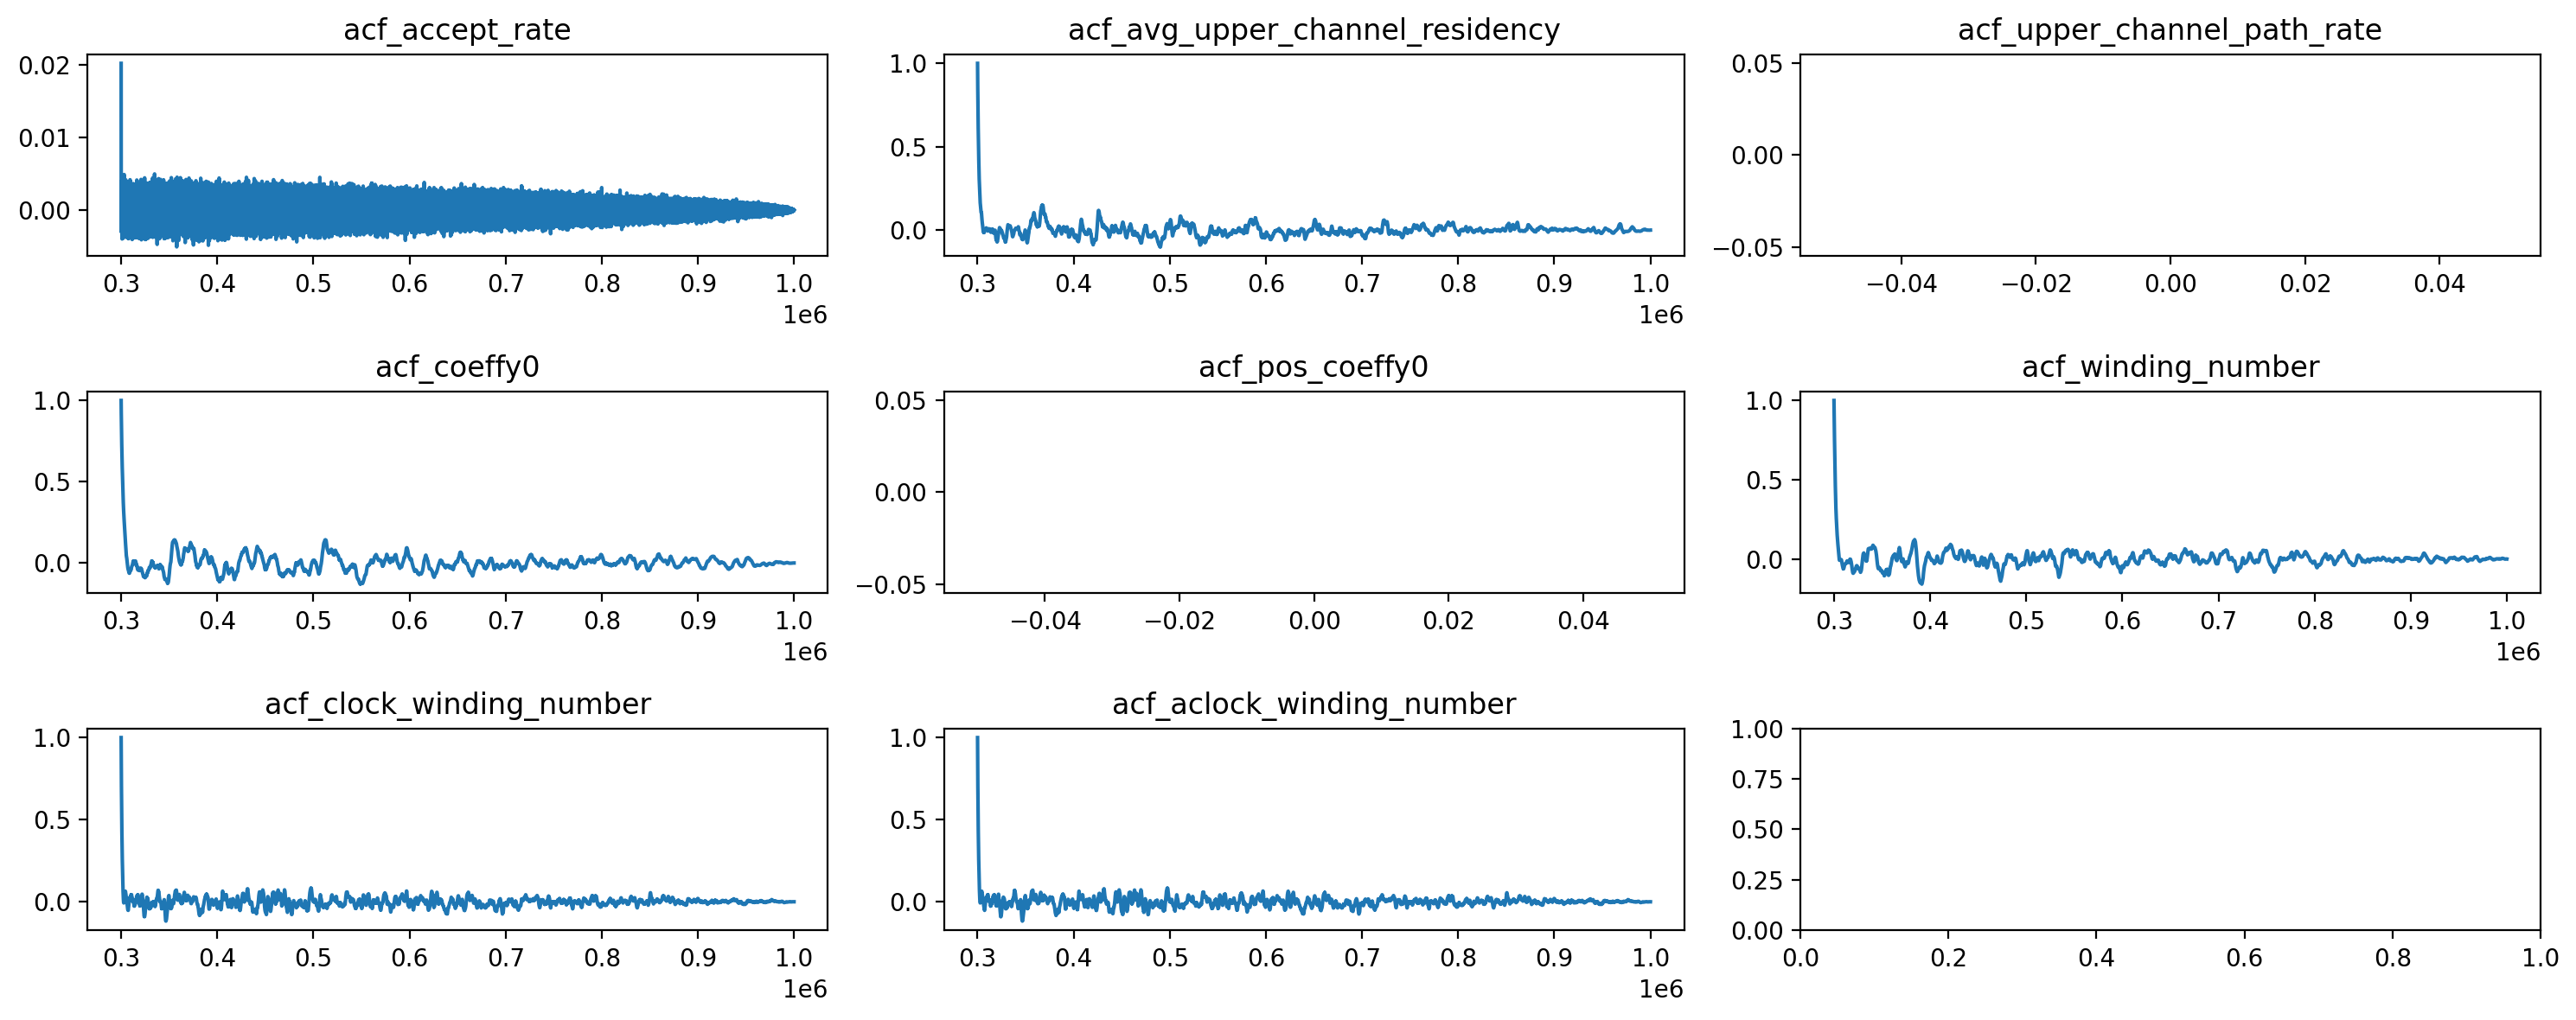

In [72]:
try:
    fig, axes = plotting.plot_time_series(_acf_observables)
    plt.tight_layout()
    sim_result.save_figure(fig, 'acf_observables')
    fig.show()
except Exception as e:
    sim_result.log_error('acf_observables', e)

Saving figure tau_acf_observables


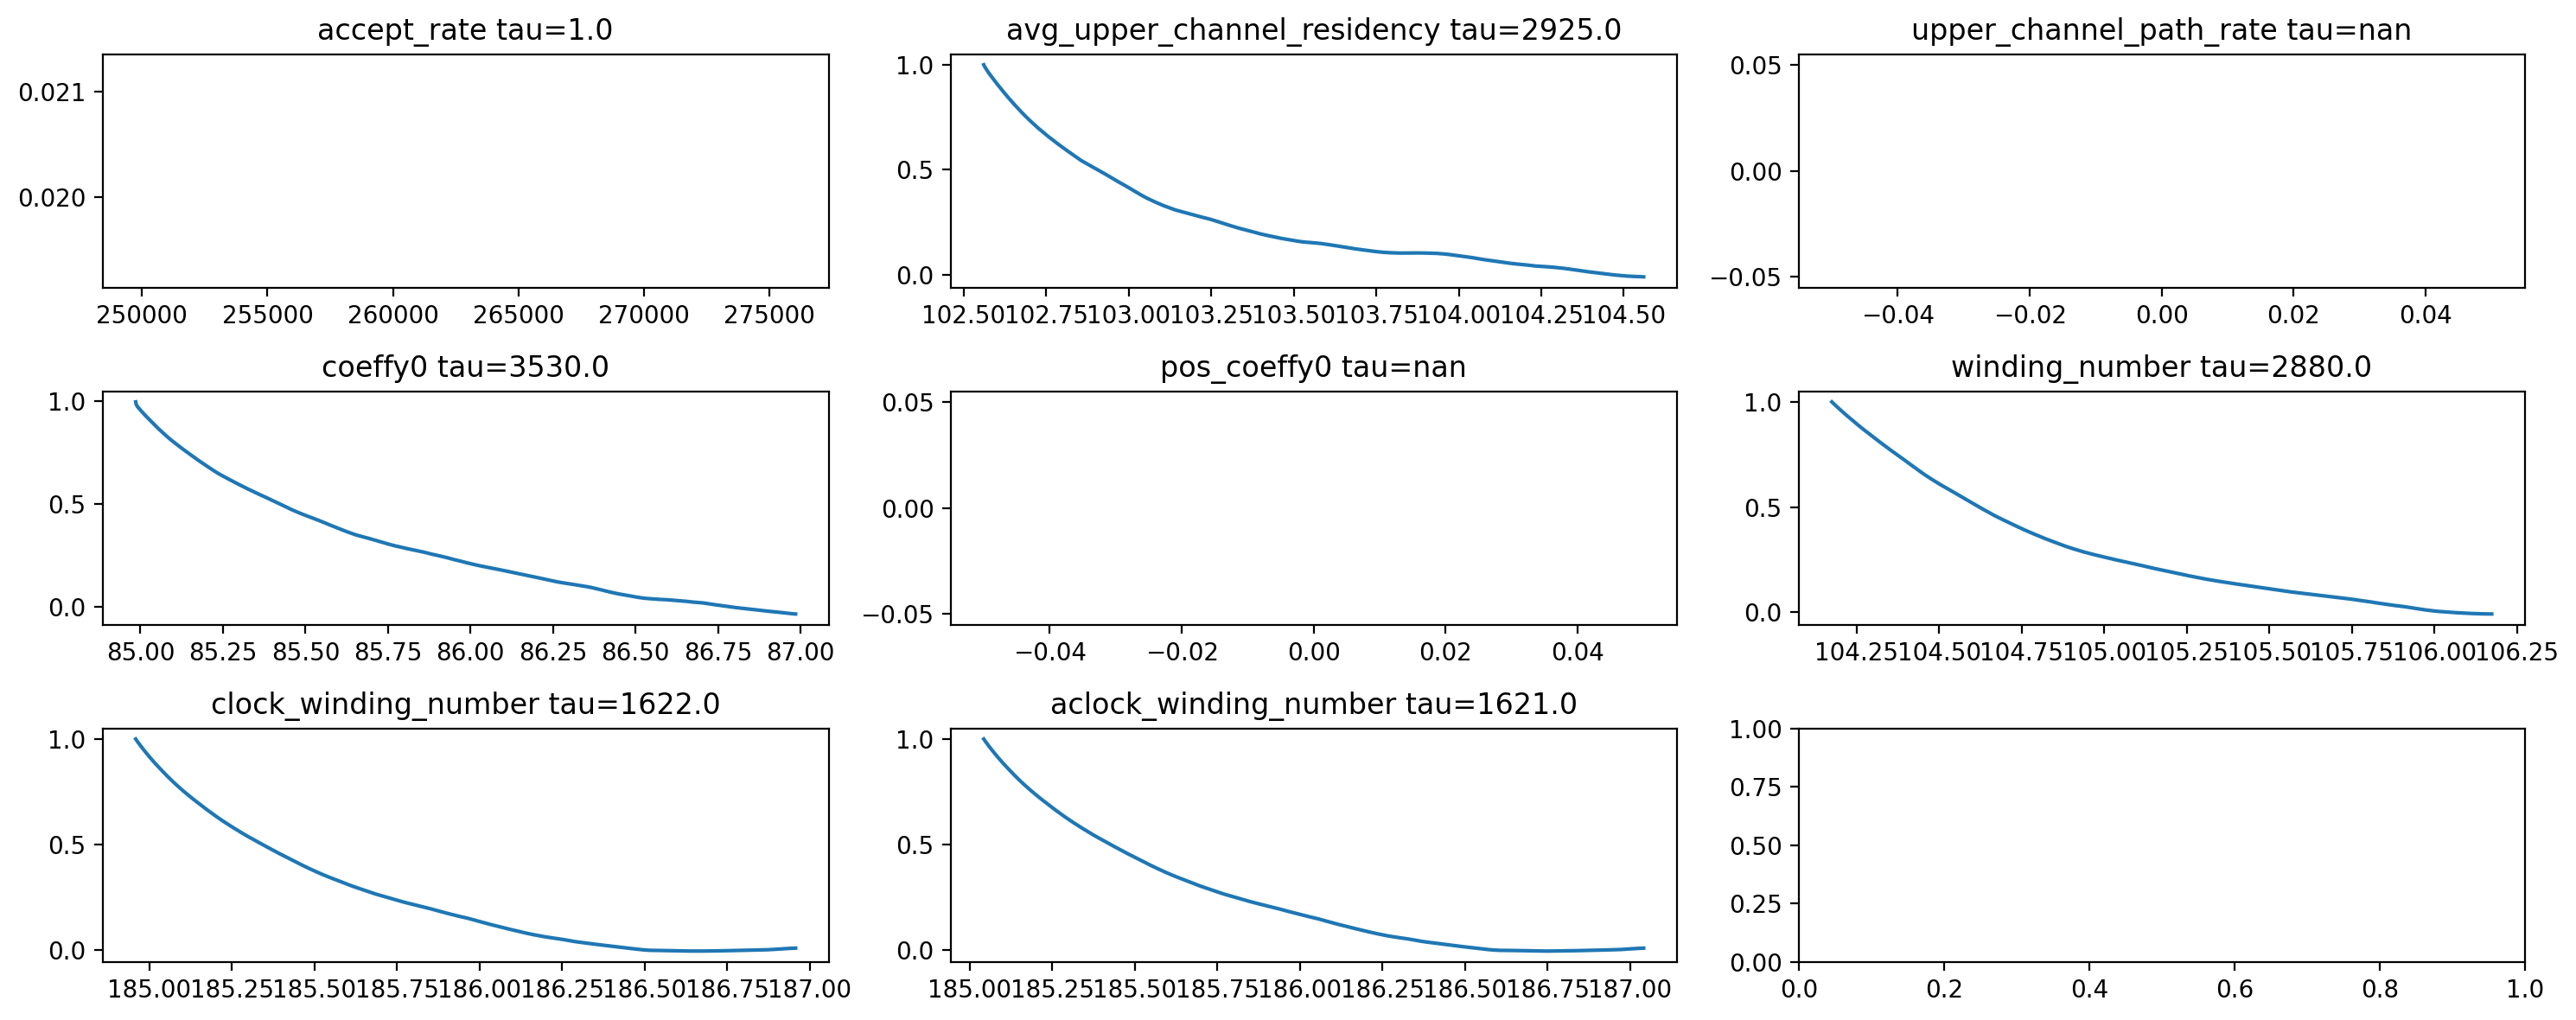

In [73]:
try:
    shortened_acf_observables = {}
    for k in observables:
        if not 'tau_' + k in calcs:
            continue
        cutoff = min(2*np.round(calcs['tau_' + k]), len(_acf_observables['acf_%s' % k]))
        if np.isnan(cutoff):
            cutoff = 1
        else:
            cutoff = int(cutoff)

        shortened_acf_observables[k] = _acf_observables['acf_%s' % k][:cutoff]
        shortened_acf_observables['steps_' + k] = (_acf_observables['steps'] / calcs['tau_' + k])[:cutoff]

        shortened_acf_observables['label_' + k] = '%s tau=%s' % (k, np.round(calcs['tau_' + k]))
    
    fig, axes = plotting.plot_time_series(shortened_acf_observables)
    plt.tight_layout()
    sim_result.save_figure(fig, 'tau_acf_observables')
    fig.show()
except Exception as e:
    sim_result.log_error('tau_acf_observables', e)

Saving figure acf_observables


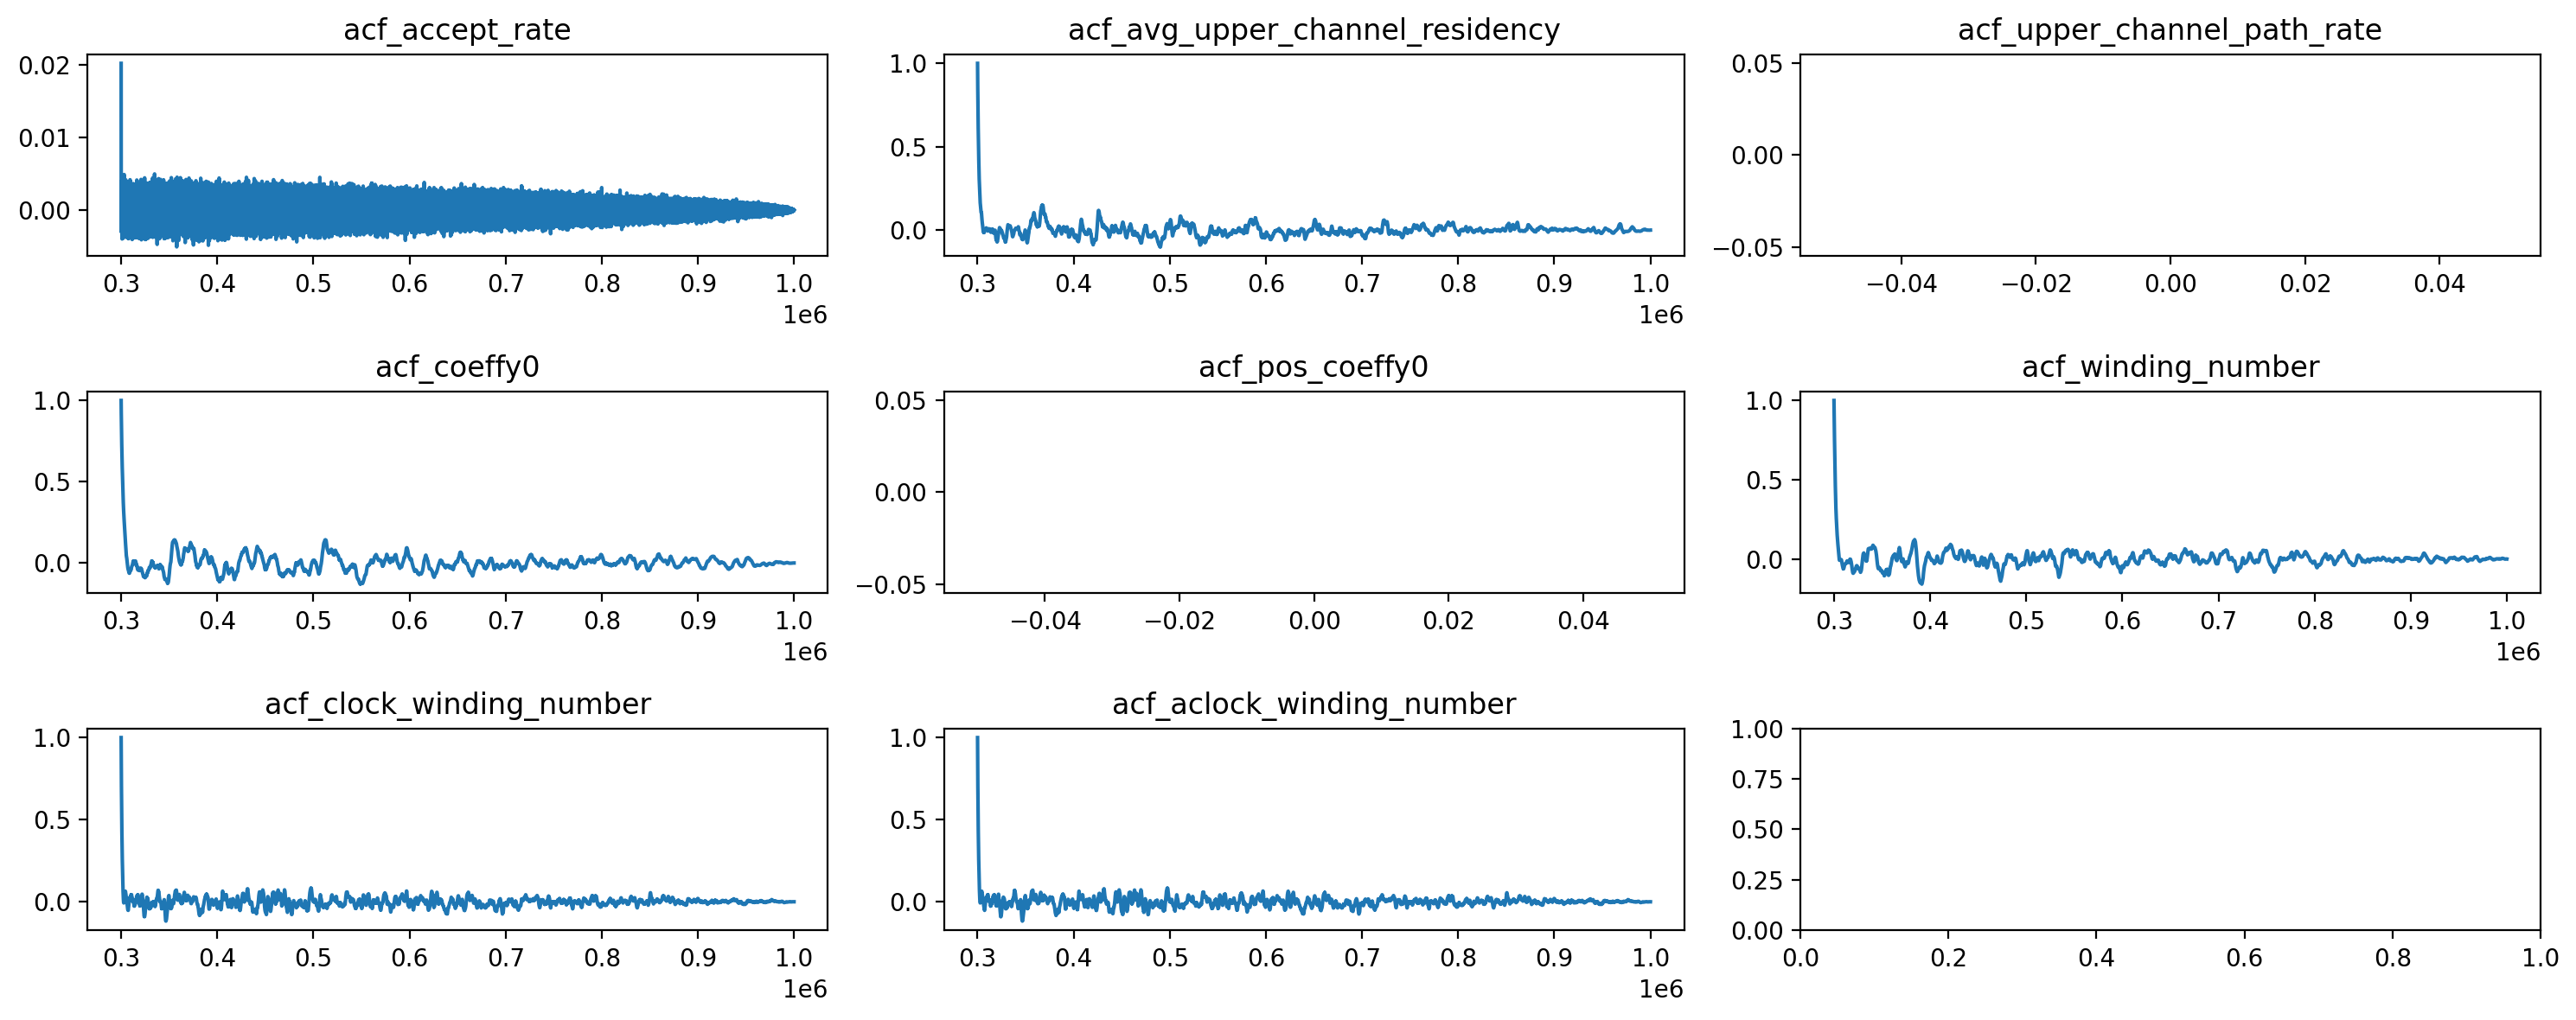

In [74]:
try:
    fig, axes = plotting.plot_time_series(_acf_observables)
    plt.tight_layout()
    sim_result.save_figure(fig, 'acf_observables')
    fig.show()
except Exception as e:
    sim_result.log_error('acf_observables', e)

Saving figure trace_observables


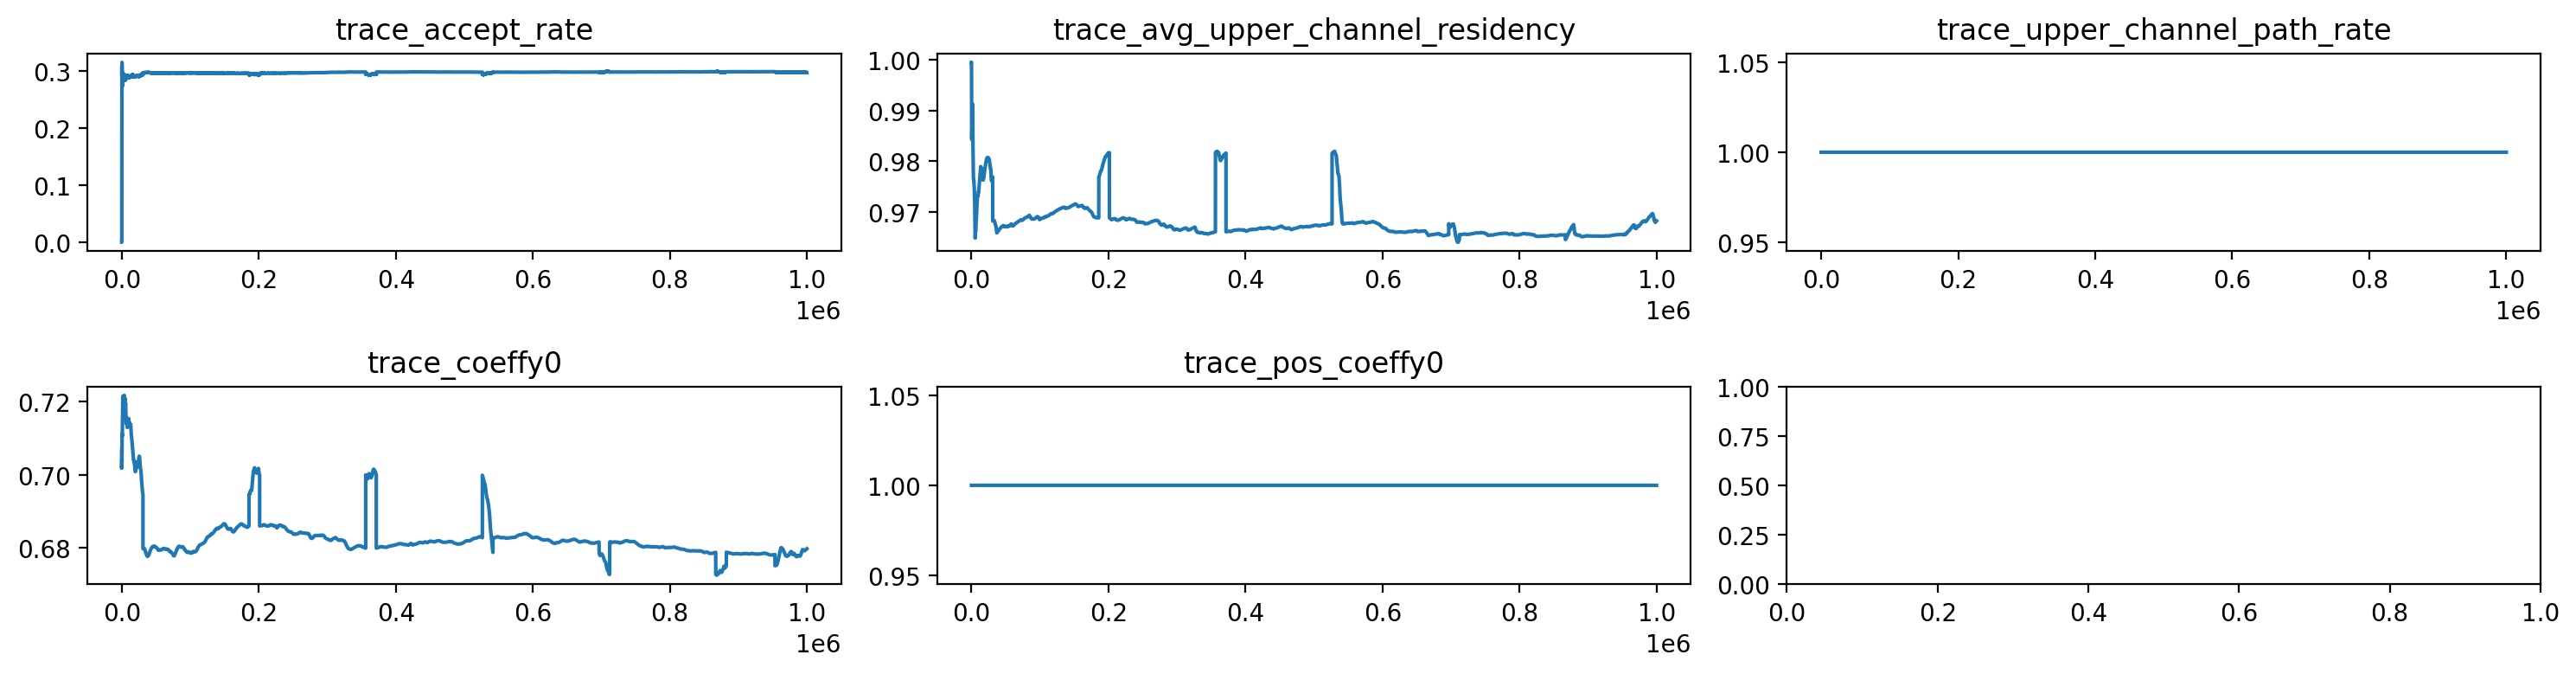

In [75]:
try:
    fig, axes = plotting.plot_time_series(_trace_observables)
    plt.tight_layout()
    sim_result.save_figure(fig, 'trace_observables')
    fig.show()
except Exception as e:
    sim_result.log_error('trace_observables', e)

Saving figure second_half_trace_observables


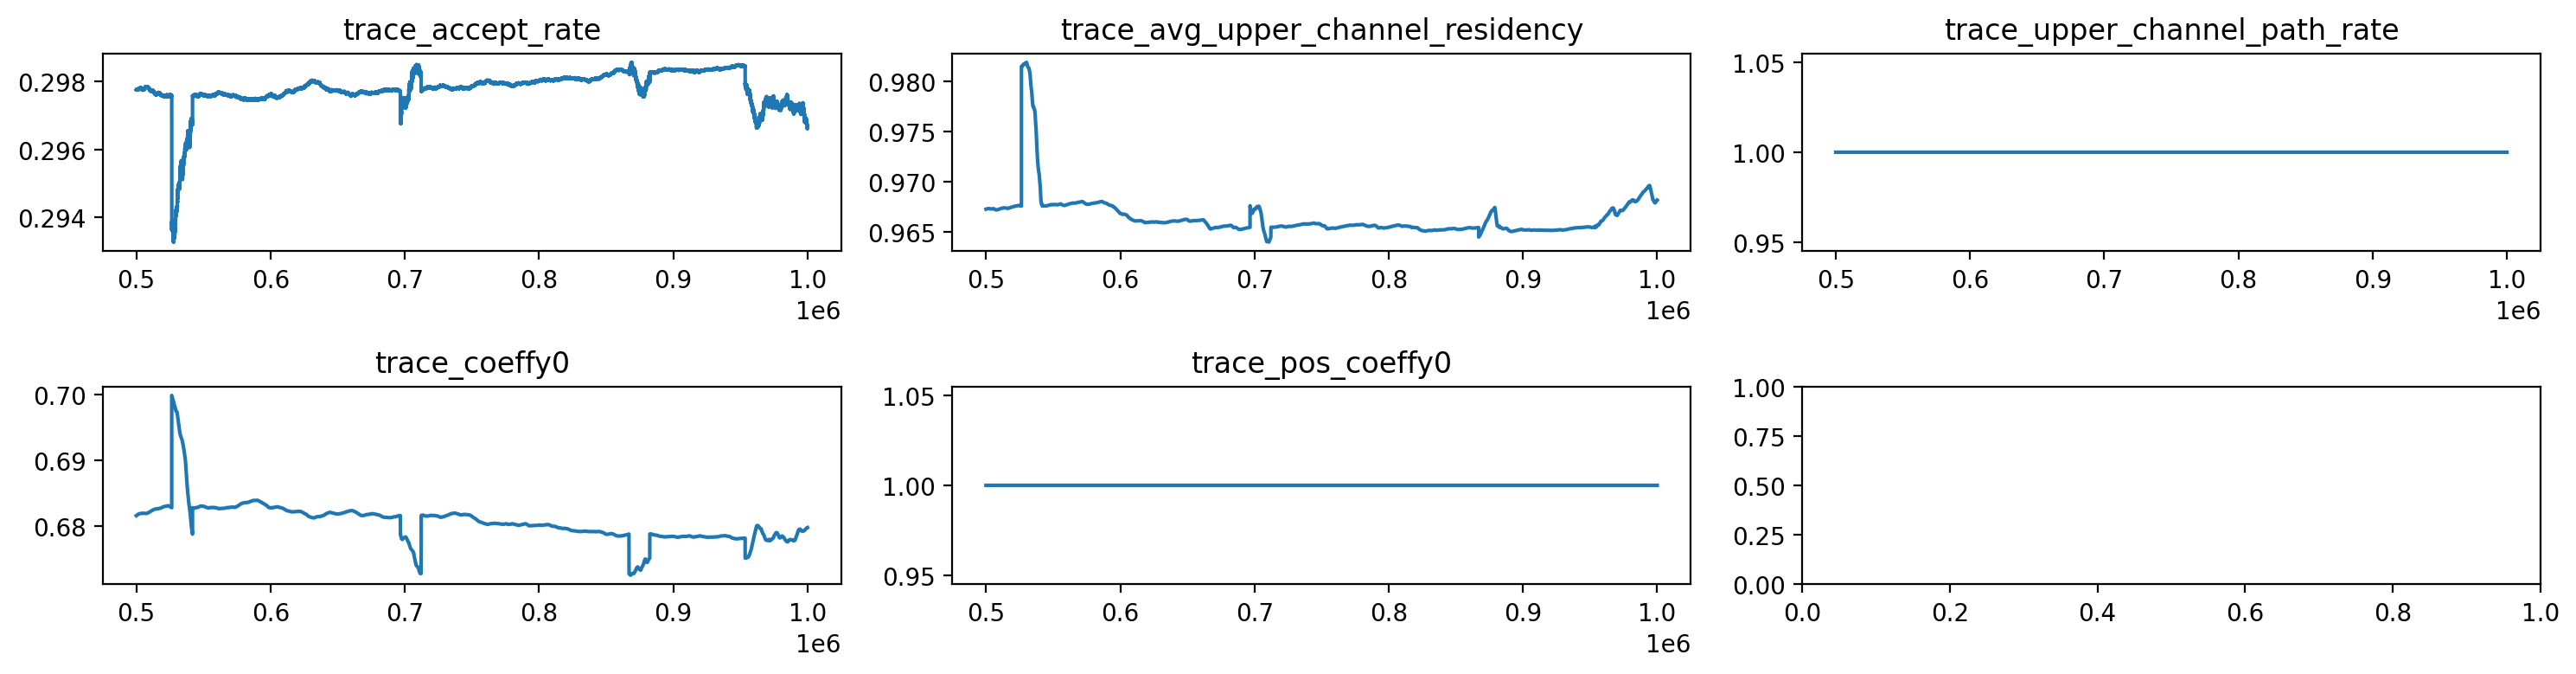

In [76]:
try:
    second_half_trace_observables = {}
    for k in observables:
        if not 'trace_%s' % k in _trace_observables:
            continue
        
        l = len(_trace_observables['trace_%s' % k])
        second_half_trace_observables['trace_%s' % k] = _trace_observables['trace_%s' % k][int(np.round(l/2)):]
        
    second_half_trace_observables['steps'] = _trace_observables['steps'][int(np.round(l/2)):]
    
    fig, axes = plotting.plot_time_series(second_half_trace_observables)
    plt.tight_layout()
    sim_result.save_figure(fig, 'second_half_trace_observables')
    fig.show()
    
    del second_half_trace_observables
except Exception as e:
    sim_result.log_error('second_half_trace_observables', e)

In [77]:
#try:
#    fig, axes = plotting.plot_time_series_rms(intermediate_expected_observables)
#    plt.tight_layout()
#    sim_result.save_figure(fig, 'intermediate_expected_observables_rms')
#    fig.show()
#except Exception as e:
#    sim_result.log_error('intermediate_expected_observables_rms', e)

In [78]:
#try:
#    fig, axes = plotting.plot_time_series_rms_window(intermediate_expected_observables, intermediate_observables_rms_window)
#    plt.tight_layout()
#    sim_result.save_figure(fig, 'intermediate_expected_observables_rms_window')
#    fig.show()
#except Exception as e:
#    sim_result.log_error('intermediate_expected_observables_rms_window', e)

In [79]:
sim_result.remove_note('UNFINISHED')
sim_result.save_note('DONE', str(datetime.datetime.now()))

In [80]:
param_dicts = {}
for k, v in globals().items():
    if k.endswith('_params') and type(v) == dict:
        param_dicts[k] = v
sim_result.save_pkl('params', param_dicts)

In [81]:
sim_result.save_calculations(calcs)
sim_result.save_pkl('sim_states', sim_states)
sim_result.save_pkl('observables', _observables)
sim_result.save_pkl('trace_observables', _trace_observables)
sim_result.save_pkl('acf_observables', _acf_observables)

In [82]:
for k in observables:
    if sim_result.data_exists(k):
        sim_result.delete_data(k)
    if sim_result.data_exists('trace_%s' % k):
        sim_result.delete_data('trace_%s' % k)
    if sim_result.data_exists('acf_%s' % k):
        sim_result.delete_data('acf_%s' % k)

In [83]:
sim_result.move_from_progress_to_output()
sim_result.remove_status_file()